# Avaliação do Plano Diretor

Agora que estimamos a variação na densidade populacional por quadra viária, podemos utilizar essa estimativa para avaliar a eficácia do Plano Diretor no controle dessa variação.

Para isso, vamos avaliar se pertencer a um dos Eixos de Estruturação da Transformação Urbana — que visam potencializar o aproveitamento do solo urbano ao longo da rede de transporte coletivo de média e alta capacidade, bem como buscar a integração territorial das políticas públicas de transporte, habitação, emprego e equipamentos sociais — leva as quadras a ter um aumento na densidade populacional, que é característico da verticalização.

E, além do pertencimento ou não a um Eixos de Estruturação da Transformação Urbana, avaliaremos também a influência de outras variáveis (cofatores) para a redução de possíveis viéses.

# Setup inicial e carregamento dos dados

In [1]:
import logging
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from linearmodels.panel import PanelOLS
import numpy as np
from stargazer.stargazer import Stargazer, LineLocation


from utils.downloads import (
    download_geosampa_shapefile
)

In [2]:
logging.basicConfig(level=logging.INFO)
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})

In [3]:
quadras_estimativa_path = 'data/11_estimativa_quadras.parquet'
quadras = gpd.read_parquet(quadras_estimativa_path)

In [4]:
quadras = quadras.rename(columns={'censo':'ano', 'dens':'densidade'})

In [5]:
quadras.head()

,geometry,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total,pop_total_min,...,dom_total_min,dom_total_max,densidade,ano,var_pop,var_dom,var_dens,rend_total_2010,rend_pc_2010,ult_pct_rend_2010
0,"POLYGON ((338344.482 7407584.661, 338344.543 7...",1,52943,Quadra,1:1.000,2004,7650,SMUL/GEOINFO,63.0,0.0,...,0.0,501.0,8235.294118,2000,NaN,NaN,NaN,56948.71241,605.837366,False
1,"POLYGON ((327186.316 7377154.793, 327188.886 7...",2,4,Praca_Canteiro,1:1.000,2004,11,SMUL/GEOINFO,0.0,0.0,...,0.0,0.0,0.000000,2000,NaN,NaN,NaN,NaN,NaN,None
2,"POLYGON ((324545.386 7402131.104, 324544.170 7...",3,5,Praca_Canteiro,1:1.000,2004,6,SMUL/GEOINFO,0.0,0.0,...,0.0,0.0,0.000000,2000,NaN,NaN,NaN,NaN,NaN,None
3,"POLYGON ((326273.589 7399282.971, 326273.013 7...",4,6,Praca_Canteiro,1:1.000,2004,109,SMUL/GEOINFO,0.0,0.0,...,0.0,0.0,0.000000,2000,NaN,NaN,NaN,NaN,NaN,None
4,"POLYGON ((322149.447 7392535.031, 322154.771 7...",5,7,Praca_Canteiro,1:1.000,2004,12,SMUL/GEOINFO,0.0,0.0,...,0.0,0.0,0.000000,2000,NaN,NaN,NaN,NaN,NaN,None


In [6]:
SHP_TOMB="14_Patrim%F4nio%20Cultural%5C%5CBens%20Protegidos%5C%5CShapefile%5C%5CSIRGAS_SHP_benstombados"
SHP_BAIRRO_AMB="14_Patrim%F4nio%20Cultural%5C%5CBens%20Protegidos%5C%5CShapefile%5C%5CSIRGAS_SHP_bairroambiental"
SHP_CONTAMIN="24_Licenciamento%20Ambiental%5C%5C%C1rea%20Contaminada%20e%20Reabilitada%5C%5CShapefile%5C%5CSIRGAS_SHP_areacontaminadareabilitada"
SHP_RISCO_GEOLOGICO="07_Prote%E7%E3o%20e%20Defesa%20Civil%5C%5CArea_Risco_Geologico_Atual%5C%5CShapefile%5C%5CSIRGAS_SHP_riscogeologicoatual"
SHP_REST_GEOTECNICA="10_Meio%20F%EDsico%5C%5CRestri%E7%E3o%20Geot%E9cnica%5C%5CShapefile%5C%5CSIRGAS_SHP_restricaogeotecnica"
SHP_REMANESC_MATA="09_Verde%20e%20Recursos%20Naturais\\PMMA\\Shapefile\\SIRGAS_SHP_resevamataatlantica"
SHP_TERRA_INDIGENA="13_Legisla%E7%E3o%20Urbana%5C%5CTerras%20Ind%EDgenas%5C%5CShapefile%5C%5CSIRGAS_SHP_TERRA_INDIGENA"
SHP_PARQUES_UCS="09_Verde%20e%20Recursos%20Naturais\\Cadparcs_Unidades_Conservacao\\Shapefile\\SIRGAS_SHP_CADPARCS_PARQUE_UNIDADE_CONSERVACAO"
SHP_AREA_PUB="12_Cadastro\\Cadastro_Area_Publica\\Shapefile\\SIRGAS_SHP_cadastroareapublica"
SHP_EIXOS="13_Legisla%E7%E3o%20Urbana%5C%5CPDE%5C%5CShapefile%5C%5CPDE_Lei_16050-14_03_Eixos%20de%20Estrutura%E7%E3o%20da%20Transforma%E7%E3o%20Urbana"

shapefiles = {
        'tombamento': {
            'remote_filename': SHP_TOMB,
            'local_filepath': None,
            'shapefile_path': 'SIRGAS_SHP_benstombados/SIRGAS_SHP_benstombados.shp'
        },
        'bairro_amb': {
            'remote_filename': SHP_BAIRRO_AMB,
            'local_filepath': None,
            'shapefile_path': 'SIRGAS_SHP_bairroambiental/SIRGAS_SHP_bairroambiental_polygon.shp'
        },
        'contamin': {
            'remote_filename': SHP_CONTAMIN,
            'local_filepath': None,
            'shapefile_path': 'SIRGAS_SHP_areacontaminadareabilitada/SIRGAS_SHP_areacontaminadareabilitada.shp'
        },
        'risco_geol': {
            'remote_filename': SHP_RISCO_GEOLOGICO,
            'local_filepath': None,
            'shapefile_path': [
                 'SIRGAS_SHP_riscogeologicoatual_AD.shp',
                 'SIRGAS_SHP_riscogeologicoatual_AF.shp',
                 'SIRGAS_SHP_riscogeologicoatual_BT.shp',
                 'SIRGAS_SHP_riscogeologicoatual_CL.shp',
                 'SIRGAS_SHP_riscogeologicoatual_CS.shp',
                 'SIRGAS_SHP_riscogeologicoatual_CT.shp',
                 'SIRGAS_SHP_riscogeologicoatual_CV.shp',
                 'SIRGAS_SHP_riscogeologicoatual_EM.shp',
                 'SIRGAS_SHP_riscogeologicoatual_FO.shp',
                 'SIRGAS_SHP_riscogeologicoatual_G.shp',
                 'SIRGAS_SHP_riscogeologicoatual_IP.shp',
                 'SIRGAS_SHP_riscogeologicoatual_IQ.shp',
                 'SIRGAS_SHP_riscogeologicoatual_IT.shp',
                 'SIRGAS_SHP_riscogeologicoatual_JA.shp',
                 'SIRGAS_SHP_riscogeologicoatual_JT.shp',
                 'SIRGAS_SHP_riscogeologicoatual_LA.shp',
                 'SIRGAS_SHP_riscogeologicoatual_MB.shp',
                 'SIRGAS_SHP_riscogeologicoatual_MG.shp',
                 'SIRGAS_SHP_riscogeologicoatual_MO.shp',
                 'SIRGAS_SHP_riscogeologicoatual_MP.shp',
                 'SIRGAS_SHP_riscogeologicoatual_PA.shp',
                 'SIRGAS_SHP_riscogeologicoatual_PE.shp',
                 'SIRGAS_SHP_riscogeologicoatual_PJ.shp',
                 'SIRGAS_SHP_riscogeologicoatual_PR.shp',
                 'SIRGAS_SHP_riscogeologicoatual_SA.shp',
                 'SIRGAS_SHP_riscogeologicoatual_SB.shp',
                 'SIRGAS_SHP_riscogeologicoatual_SM.shp',
                 'SIRGAS_SHP_riscogeologicoatual_ST.shp',
                 'SIRGAS_SHP_riscogeologicoatual_VP.shp'
            ]
        },
        'risco_geot': {
            'remote_filename': SHP_REST_GEOTECNICA,
            'local_filepath': None,
            'shapefile_path': 'SIRGAS_SHP_restricaogeotecnica/SIRGAS_SHP_restricaogeotecnica.shp'
        },
        'reman_mataatl': {
            'remote_filename': SHP_REMANESC_MATA,
            'local_filepath': None,
            'shapefile_path': 'SIRGAS_SHP_resevamataatlantica/SIRGAS_SHP_resevamataatlantica_polygon.shp'
        },
        'terra_ind': {
            'remote_filename': SHP_TERRA_INDIGENA,
            'local_filepath': None,
            'shapefile_path': 'SIRGAS_SHP_TERRA_INDIGENA/SIRGAS_SHP_TERRA_INDIGENA.shp'
        },
        'parques_ucs': {
            'remote_filename': SHP_PARQUES_UCS,
            'local_filepath': None,
            'shapefile_path': 'SIRGAS_SHP_CADPARCS_PARQUE_UNIDADE_CONSERVACAO/SIRGAS_SHP_CADPARCS_PARQUE_UNIDADE_CONSERVACAO.shp'
        },
        'area_pub': {
            'remote_filename': SHP_AREA_PUB,
            'local_filepath': None,
            'shapefile_path': 'SIRGAS_SHP_cadastroareapublica/SIRGAS_SHP_cadastroareapublica.shp'
        },
        'eixos_etu': {
            'remote_filename': SHP_EIXOS,
            'local_filepath': None,
            'shapefile_path': 'sirgas_PDE_3-Eixos-EETU.shp'
        }
}

In [7]:
for k in shapefiles.keys():
    sf = shapefiles.get(k)
    sf['local_filepath'] = download_geosampa_shapefile(sf['remote_filename'])

INFO:root:O arquivo data/cache/geosampa_shp/SIRGAS_SHP_benstombados.zip já foi baixado anteriormente. Usando cache local.
INFO:root:O arquivo data/cache/geosampa_shp/SIRGAS_SHP_bairroambiental.zip já foi baixado anteriormente. Usando cache local.
INFO:root:O arquivo data/cache/geosampa_shp/SIRGAS_SHP_areacontaminadareabilitada.zip já foi baixado anteriormente. Usando cache local.
INFO:root:O arquivo data/cache/geosampa_shp/SIRGAS_SHP_riscogeologicoatual.zip já foi baixado anteriormente. Usando cache local.
INFO:root:O arquivo data/cache/geosampa_shp/SIRGAS_SHP_restricaogeotecnica.zip já foi baixado anteriormente. Usando cache local.
INFO:root:O arquivo data/cache/geosampa_shp/SIRGAS_SHP_resevamataatlantica.zip já foi baixado anteriormente. Usando cache local.
INFO:root:O arquivo data/cache/geosampa_shp/SIRGAS_SHP_TERRA_INDIGENA.zip já foi baixado anteriormente. Usando cache local.
INFO:root:O arquivo data/cache/geosampa_shp/SIRGAS_SHP_CADPARCS_PARQUE_UNIDADE_CONSERVACAO.zip já foi baix

# Criando a dummy de participação em Eixos de Estruturação da Transformação Urbana

In [8]:
eixos = gpd.read_file(
    f'{shapefiles.get('eixos_etu').get('local_filepath')}!{shapefiles.get('eixos_etu').get('shapefile_path')}'
)
eixos = eixos.set_crs('EPSG:31983')
eixos.head()

,sg_macro_d,cd_perimet,nm_perimet,qt_area_pe,nm_tema_di,tx_macro_d,cd_macro_d,cd_tema_di,geometry
0,EETU,1291,Area de Influencia,3270.1400,Eixos de Estruturação da Transformação Urbana,Eixos da Estruturação da Transformação Urbana,53,3,"POLYGON ((339102.073 7390875.968, 339092.977 7..."
1,EETU,1293,Area de Influencia,10253.8000,Eixos de Estruturação da Transformação Urbana,Eixos da Estruturação da Transformação Urbana,53,3,"POLYGON ((339175.255 7391137.486, 339179.609 7..."
2,EETU,1301,Area de Influencia,13803.7800,Eixos de Estruturação da Transformação Urbana,Eixos da Estruturação da Transformação Urbana,53,3,"POLYGON ((328045.678 7386193.996, 328042.792 7..."
3,EETU,1304,Area de Influencia,1304.1400,Eixos de Estruturação da Transformação Urbana,Eixos da Estruturação da Transformação Urbana,53,3,"POLYGON ((327580.091 7386139.507, 327578.466 7..."
4,EETU,1343,Area de Influencia,18107.1100,Eixos de Estruturação da Transformação Urbana,Eixos da Estruturação da Transformação Urbana,53,3,"POLYGON ((327806.146 7375136.374, 327831.750 7..."


In [9]:
%%time
quadras_eixos = gpd.overlay(
        quadras,
        eixos,
        how='intersection',
        keep_geom_type=True
)
quadras_eixos

CPU times: user 2.34 s, sys: 0 ns, total: 2.34 s
Wall time: 2.49 s


,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total,pop_total_min,pop_total_max,...,ult_pct_rend_2010,sg_macro_d,cd_perimet,nm_perimet,qt_area_pe,nm_tema_di,tx_macro_d,cd_macro_d,cd_tema_di,geometry
0,130,171,Praca_Canteiro,1:1.000,2004,1600,SMUL/GEOINFO,0.0,0.0,0.0,...,None,EETU,2040,Area de Influencia,16006.3400,Eixos de Estruturação da Transformação Urbana,Eixos da Estruturação da Transformação Urbana,53,3,"POLYGON ((356469.572 7401103.257, 356469.570 7..."
1,187,247,Quadra,1:1.000,2017,34359,SMUL/GEOINFO,347.0,0.0,985.0,...,False,EETU,1616,Area de Influencia,21405.2000,Eixos de Estruturação da Transformação Urbana,Eixos da Estruturação da Transformação Urbana,53,3,"POLYGON ((345576.802 7397270.692, 345578.146 7..."
2,187,247,Quadra,1:1.000,2017,34359,SMUL/GEOINFO,347.0,0.0,985.0,...,False,EETU,1617,Area de Influencia,21405.2000,Eixos de Estruturação da Transformação Urbana,Eixos da Estruturação da Transformação Urbana,53,3,"POLYGON ((345576.802 7397270.692, 345578.146 7..."
3,188,248,Quadra,1:1.000,2017,3446,SMUL/GEOINFO,35.0,0.0,985.0,...,False,EETU,391,Area de Influencia,2453.4800,Eixos de Estruturação da Transformação Urbana,Eixos da Estruturação da Transformação Urbana,53,3,"POLYGON ((345402.230 7397291.473, 345401.828 7..."
4,188,248,Quadra,1:1.000,2017,3446,SMUL/GEOINFO,35.0,0.0,985.0,...,False,EETU,1616,Area de Influencia,21405.2000,Eixos de Estruturação da Transformação Urbana,Eixos da Estruturação da Transformação Urbana,53,3,"POLYGON ((345472.815 7397273.663, 345471.983 7..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15925,64668,75193,Quadra,1:1.000,2017,124074,SMUL/GEOINFO,1101.0,673.0,1677.0,...,False,EETU,1092,Area de Influencia,6510.8700,Eixos de Estruturação da Transformação Urbana,Eixos da Estruturação da Transformação Urbana,53,3,"POLYGON ((351335.837 7389154.314, 351337.467 7..."
15926,64750,83000,Praca_Canteiro,1:1.000,2017,1908,SMUL/GEOINFO,0.0,0.0,0.0,...,None,EETU,4540,Area de Influencia,2622.8300,Eixos de Estruturação da Transformação Urbana,Eixos da Estruturação da Transformação Urbana,53,3,"POLYGON ((321658.879 7380598.598, 321658.628 7..."
15927,64751,83000,Praca_Canteiro,1:1.000,2017,1908,SMUL/GEOINFO,0.0,0.0,0.0,...,None,EETU,4925,Area de Influencia,2507.2000,Eixos de Estruturação da Transformação Urbana,Eixos da Estruturação da Transformação Urbana,53,3,"POLYGON ((321545.637 7380515.630, 321542.000 7..."
15928,64751,83000,Praca_Canteiro,1:1.000,2017,1908,SMUL/GEOINFO,0.0,0.0,0.0,...,None,EETU,4928,Area de Influencia,17901.6300,Eixos de Estruturação da Transformação Urbana,Eixos da Estruturação da Transformação Urbana,53,3,"MULTIPOLYGON (((321522.486 7380516.588, 321502..."


In [10]:
quadras = (
    quadras
    .assign(
        in_eixo=quadras['cd_identificador_quadra_viaria_editada'].isin(quadras_eixos['cd_identificador_quadra_viaria_editada'])
    )
)
quadras

,geometry,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total,pop_total_min,...,dom_total_max,densidade,ano,var_pop,var_dom,var_dens,rend_total_2010,rend_pc_2010,ult_pct_rend_2010,in_eixo
0,"POLYGON ((338344.482 7407584.661, 338344.543 7...",1,52943,Quadra,1:1.000,2004,7650,SMUL/GEOINFO,63.0,0.0,...,501.0,8235.294118,2000,NaN,NaN,NaN,5.694871e+04,605.837366,False,False
1,"POLYGON ((327186.316 7377154.793, 327188.886 7...",2,4,Praca_Canteiro,1:1.000,2004,11,SMUL/GEOINFO,0.0,0.0,...,0.0,0.000000,2000,NaN,NaN,NaN,NaN,NaN,None,False
2,"POLYGON ((324545.386 7402131.104, 324544.170 7...",3,5,Praca_Canteiro,1:1.000,2004,6,SMUL/GEOINFO,0.0,0.0,...,0.0,0.000000,2000,NaN,NaN,NaN,NaN,NaN,None,False
3,"POLYGON ((326273.589 7399282.971, 326273.013 7...",4,6,Praca_Canteiro,1:1.000,2004,109,SMUL/GEOINFO,0.0,0.0,...,0.0,0.000000,2000,NaN,NaN,NaN,NaN,NaN,None,False
4,"POLYGON ((322149.447 7392535.031, 322154.771 7...",5,7,Praca_Canteiro,1:1.000,2004,12,SMUL/GEOINFO,0.0,0.0,...,0.0,0.000000,2000,NaN,NaN,NaN,NaN,NaN,None,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194347,"POLYGON ((325071.550 7397335.276, 325073.371 7...",64780,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,0.0,0.000000,2022,0.0,0.0,0.000000,NaN,NaN,None,False
194348,"POLYGON ((325064.631 7397341.102, 325065.814 7...",64781,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,0.0,0.000000,2022,0.0,0.0,0.000000,NaN,NaN,None,False
194349,"POLYGON ((325102.327 7397333.002, 325089.121 7...",64782,58914,Praca_Canteiro,1:1.000,2004,25982,SMUL/GEOINFO,0.0,0.0,...,0.0,0.000000,2022,0.0,0.0,0.000000,NaN,NaN,None,False
194350,"POLYGON ((325081.631 7397226.147, 325087.148 7...",64783,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,0.0,0.000000,2022,0.0,0.0,0.000000,NaN,NaN,None,False


# Criando as dummies de cofatores

## Bens tombados

In [11]:
tombamento = gpd.read_file(
    f'{shapefiles.get('tombamento').get('local_filepath')}!{shapefiles.get('tombamento').get('shapefile_path')}'
)
tombamento = tombamento.set_crs('EPSG:31983')
tombamento.head()

,bp_id,bp_nome,bp_setor,bp_quadra,bp_lote,bp_cond,bp_compres,bp_condeph,bp_iphan,bp_enderec,...,bp_tpcateg,bp_categor,bp_status,bp_distrit,bp_subpref,bp_proconp,bp_procond,bp_proipha,bp_obscomp,geometry
0,None,BAIRRO DA BELA VISTA,005,086,0059,00,RES. 22/02,não consta,não consta,"R CONDE DE SÃO JOAQUIM, 231",...,BIR,Bens Imóveis Representativos,TOMBADO,BELA VISTA,SÉ,1990-0.004.514-2,None,não consta,None,"POLYGON ((332719.960 7393752.388, 332729.855 7..."
1,None,CONGREGAÇÃO PEQUENAS IRMAS DIVINA PROVIDENCIA ...,003,034,0024,00,RES. 06/16,não consta,não consta,"R WANDENKOLK, 514",...,None,None,TOMBADO,BRÁS,SÉ,None,None,não consta,None,"POLYGON ((334258.178 7394302.924, 334243.304 7..."
2,None,FÁBRICA LABOR,003,045,0044,00,RES. 22/17,RES. SC 101/2014,não consta,"R DA MOOCA, 699",...,None,None,TOMBADO,BRÁS,SÉ,None,None,não consta,None,"POLYGON ((334773.813 7394273.337, 334803.080 7..."
3,None,CONGREGAÇÃO PEQUENAS IRMAS DIVINA PROVIDENCIA ...,003,034,0001,00,RES. 06/16,não consta,não consta,"R DA MOOCA, 93",...,None,None,TOMBADO,BRÁS,SÉ,None,None,não consta,None,"POLYGON ((334206.659 7394316.266, 334207.600 7..."
4,None,FÁBRICA LABOR,003,045,0043,00,RES. 14/14,RES. SC 101/2014,não consta,"R DA MOOCA, 775",...,None,None,TOMBADO,BRÁS,SÉ,None,não consta,não consta,None,"POLYGON ((334818.066 7394350.141, 334839.449 7..."


In [12]:
tombamento.bp_status.value_counts()

bp_status
TOMBADO         5738
APT             1010
APT / ESTUDO     214
Name: count, dtype: int64

Como a Resolução de Abertura de Tombamento (APT) confere ao bem o mesmo regime de preservação do bem tombado até a decisão final do Conselho, a presença de qualquer status reduz a possibilidade de construção na quadra, não necessitando nenhum filtro adicional antes da interseção geográfica.

In [13]:
%%time
quadras_tombamento = gpd.overlay(
        quadras,
        tombamento,
        how='intersection',
        keep_geom_type=True
)
quadras_tombamento

CPU times: user 3.06 s, sys: 18.6 ms, total: 3.08 s
Wall time: 3.08 s


,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total,pop_total_min,pop_total_max,...,bp_tpcateg,bp_categor,bp_status,bp_distrit,bp_subpref,bp_proconp,bp_procond,bp_proipha,bp_obscomp,geometry
0,225,290,Praca_Canteiro,1:1.000,2004,13,SMUL/GEOINFO,0.0,0.0,0.0,...,None,None,TOMBADO,None,None,6025.2020/0028014-5,None,None,None,"POLYGON ((332172.998 7395123.476, 332171.989 7..."
1,678,870,Quadra,1:1.000,2004,17744,SMUL/GEOINFO,74.0,0.0,1292.0,...,BIR,Bens Imóveis Representativos,TOMBADO,JARDIM PAULISTA,SÉ,2009-0.064.434-2 e 2017-0.144.142-6,não consta,não consta,None,"POLYGON ((330163.567 7391816.371, 330166.522 7..."
2,727,926,Quadra,1:1.000,2017,1194,SMUL/GEOINFO,12.0,0.0,1740.0,...,None,None,TOMBADO,PENHA,PE,2007-0.301.455-1; 2004-0.297.171-6; 2005-0.059...,não consta,não consta,None,"POLYGON ((341759.115 7397336.388, 341778.211 7..."
3,727,926,Quadra,1:1.000,2017,1194,SMUL/GEOINFO,12.0,0.0,1740.0,...,None,None,TOMBADO,PENHA,PE,None,não consta,não consta,None,"POLYGON ((341759.115 7397336.388, 341778.212 7..."
4,727,926,Quadra,1:1.000,2017,1194,SMUL/GEOINFO,12.0,0.0,1740.0,...,None,None,TOMBADO,PENHA,PE,2007-0.301.455-1; 2004-0.297.171-6; 2005-0.059...,não consta,não consta,None,"POLYGON ((341800.290 7397349.085, 341801.441 7..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23545,64659,98041,Quadra,1:1.000,2017,427,SMUL/GEOINFO,1.0,0.0,555.0,...,None,None,TOMBADO,PARELHEIROS,VÁRIOS,None,None,não consta,None,"POLYGON ((326558.202 7359745.191, 326553.245 7..."
23546,64660,98041,Quadra,1:1.000,2017,97857,SMUL/GEOINFO,577.0,0.0,2482.0,...,None,None,TOMBADO,PARELHEIROS,VÁRIOS,None,None,não consta,None,"POLYGON ((326553.724 7359745.170, 326551.317 7..."
23547,64661,98041,Quadra,1:1.000,2017,8818,SMUL/GEOINFO,148.0,0.0,1000.0,...,None,None,TOMBADO,PARELHEIROS,VÁRIOS,None,None,não consta,None,"POLYGON ((326539.960 7359873.744, 326534.699 7..."
23548,64662,98041,Quadra,1:1.000,2017,255,SMUL/GEOINFO,1.0,0.0,555.0,...,None,None,TOMBADO,PARELHEIROS,VÁRIOS,None,None,não consta,None,"POLYGON ((326595.376 7359875.528, 326595.685 7..."


In [14]:
quadras = (
    quadras
    .assign(
        has_tombamento=quadras['cd_identificador_quadra_viaria_editada'].isin(quadras_tombamento['cd_identificador_quadra_viaria_editada'])
    )
)
quadras

,geometry,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total,pop_total_min,...,densidade,ano,var_pop,var_dom,var_dens,rend_total_2010,rend_pc_2010,ult_pct_rend_2010,in_eixo,has_tombamento
0,"POLYGON ((338344.482 7407584.661, 338344.543 7...",1,52943,Quadra,1:1.000,2004,7650,SMUL/GEOINFO,63.0,0.0,...,8235.294118,2000,NaN,NaN,NaN,5.694871e+04,605.837366,False,False,False
1,"POLYGON ((327186.316 7377154.793, 327188.886 7...",2,4,Praca_Canteiro,1:1.000,2004,11,SMUL/GEOINFO,0.0,0.0,...,0.000000,2000,NaN,NaN,NaN,NaN,NaN,None,False,False
2,"POLYGON ((324545.386 7402131.104, 324544.170 7...",3,5,Praca_Canteiro,1:1.000,2004,6,SMUL/GEOINFO,0.0,0.0,...,0.000000,2000,NaN,NaN,NaN,NaN,NaN,None,False,False
3,"POLYGON ((326273.589 7399282.971, 326273.013 7...",4,6,Praca_Canteiro,1:1.000,2004,109,SMUL/GEOINFO,0.0,0.0,...,0.000000,2000,NaN,NaN,NaN,NaN,NaN,None,False,False
4,"POLYGON ((322149.447 7392535.031, 322154.771 7...",5,7,Praca_Canteiro,1:1.000,2004,12,SMUL/GEOINFO,0.0,0.0,...,0.000000,2000,NaN,NaN,NaN,NaN,NaN,None,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194347,"POLYGON ((325071.550 7397335.276, 325073.371 7...",64780,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,0.000000,2022,0.0,0.0,0.000000,NaN,NaN,None,False,False
194348,"POLYGON ((325064.631 7397341.102, 325065.814 7...",64781,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,0.000000,2022,0.0,0.0,0.000000,NaN,NaN,None,False,False
194349,"POLYGON ((325102.327 7397333.002, 325089.121 7...",64782,58914,Praca_Canteiro,1:1.000,2004,25982,SMUL/GEOINFO,0.0,0.0,...,0.000000,2022,0.0,0.0,0.000000,NaN,NaN,None,False,False
194350,"POLYGON ((325081.631 7397226.147, 325087.148 7...",64783,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,0.000000,2022,0.0,0.0,0.000000,NaN,NaN,None,False,False


## Bairros ambientais

In [15]:
bairro_amb = gpd.read_file(
    f'{shapefiles.get('bairro_amb').get('local_filepath')}!{shapefiles.get('bairro_amb').get('shapefile_path')}'
)
bairro_amb = bairro_amb.set_crs('EPSG:31983')
bairro_amb.head()

,ba_conpres,ba_link,ba_condeph,ba_fonte,ba_tipo,ba_nome,geometry
0,RES. 05/1991; RES. 07/2004 (DETALHAMENTO E COM...,https://www.prefeitura.sp.gov.br/cidade/upload...,RES. SC 02/1986; RES. COMPL. SCEC 37/2021,DPH/SMC,Bairro Ambiental,"JARDINS: AMÉRICA, EUROPA, PAULISTA E PAULISTANO","POLYGON ((329046.578 7393234.733, 329087.797 7..."
1,RES. 42/1992; RES. 09/2015 (COMPLEMENTAÇÃO),https://www.prefeitura.sp.gov.br/cidade/upload...,RES. SC 08/1991; RES. SC 12/2008 (COMPLEMENTAÇÃO),DPH/SMC,Bairro Ambiental,BAIRROS DO PACAEMBU E PERDIZES,"POLYGON ((329792.196 7394016.673, 329898.306 7..."
2,RES. 03/2009,https://www.prefeitura.sp.gov.br/cidade/upload...,não consta,DPH/SMC,Bairro Ambiental,CITY LAPA,"POLYGON ((325934.738 7397438.298, 325896.035 7..."
3,RES. 05/2002,https://www.prefeitura.sp.gov.br/cidade/upload...,não consta,DPH/SMC,Bairro Ambiental,ÁREA DO JARDIM LUSITÂNIA,"POLYGON ((331017.358 7389806.206, 331042.434 7..."
4,RES. 16/2002,https://www.prefeitura.sp.gov.br/cidade/upload...,não consta,DPH/SMC,Bairro Ambiental,ÁREA DO JARDIM DA SAUDE,"POLYGON ((334105.926 7386889.038, 334073.650 7..."


In [16]:
%%time
quadras_bamb = gpd.overlay(
        quadras,
        bairro_amb,
        how='intersection',
        keep_geom_type=True
)
quadras_bamb

CPU times: user 1.35 s, sys: 11 ms, total: 1.36 s
Wall time: 1.36 s


,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total,pop_total_min,pop_total_max,...,ult_pct_rend_2010,in_eixo,has_tombamento,ba_conpres,ba_link,ba_condeph,ba_fonte,ba_tipo,ba_nome,geometry
0,7,10,Praca_Canteiro,1:1.000,2004,563,SMUL/GEOINFO,0.0,0.0,0.0,...,None,False,False,RES. 05/1991; RES. 07/2004 (DETALHAMENTO E COM...,https://www.prefeitura.sp.gov.br/cidade/upload...,RES. SC 02/1986; RES. COMPL. SCEC 37/2021,DPH/SMC,Bairro Ambiental,"JARDINS: AMÉRICA, EUROPA, PAULISTA E PAULISTANO","POLYGON ((329175.775 7391565.401, 329212.595 7..."
1,15,24,Praca_Canteiro,1:1.000,2004,17,SMUL/GEOINFO,0.0,0.0,0.0,...,None,False,False,RES. 16/2002,https://www.prefeitura.sp.gov.br/cidade/upload...,não consta,DPH/SMC,Bairro Ambiental,ÁREA DO JARDIM DA SAUDE,"POLYGON ((334653.251 7386813.358, 334653.327 7..."
2,17,27,Praca_Canteiro,1:1.000,2004,9,SMUL/GEOINFO,0.0,0.0,0.0,...,None,False,False,RES. 16/2002,https://www.prefeitura.sp.gov.br/cidade/upload...,não consta,DPH/SMC,Bairro Ambiental,ÁREA DO JARDIM DA SAUDE,"POLYGON ((334669.967 7386823.263, 334669.453 7..."
3,18,29,Praca_Canteiro,1:1.000,2004,10,SMUL/GEOINFO,0.0,0.0,0.0,...,None,False,False,RES. 16/2002,https://www.prefeitura.sp.gov.br/cidade/upload...,não consta,DPH/SMC,Bairro Ambiental,ÁREA DO JARDIM DA SAUDE,"POLYGON ((334643.309 7386825.410, 334643.118 7..."
4,19,30,Praca_Canteiro,1:1.000,2004,11,SMUL/GEOINFO,0.0,0.0,0.0,...,None,False,False,RES. 16/2002,https://www.prefeitura.sp.gov.br/cidade/upload...,não consta,DPH/SMC,Bairro Ambiental,ÁREA DO JARDIM DA SAUDE,"POLYGON ((335286.364 7387720.988, 335286.334 7..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4054,64779,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,0.0,...,None,False,False,RES. 03/2009,https://www.prefeitura.sp.gov.br/cidade/upload...,não consta,DPH/SMC,Bairro Ambiental,CITY LAPA,"POLYGON ((325056.710 7397327.446, 325050.884 7..."
4055,64780,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,0.0,...,None,False,False,RES. 03/2009,https://www.prefeitura.sp.gov.br/cidade/upload...,não consta,DPH/SMC,Bairro Ambiental,CITY LAPA,"POLYGON ((325073.371 7397334.639, 325075.009 7..."
4056,64781,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,0.0,...,None,False,False,RES. 03/2009,https://www.prefeitura.sp.gov.br/cidade/upload...,não consta,DPH/SMC,Bairro Ambiental,CITY LAPA,"POLYGON ((325065.814 7397348.659, 325066.361 7..."
4057,64782,58914,Praca_Canteiro,1:1.000,2004,25982,SMUL/GEOINFO,0.0,0.0,0.0,...,None,False,False,RES. 03/2009,https://www.prefeitura.sp.gov.br/cidade/upload...,não consta,DPH/SMC,Bairro Ambiental,CITY LAPA,"POLYGON ((325089.121 7397330.178, 325083.021 7..."


In [17]:
quadras = (
    quadras
    .assign(
        in_bairro_ambiental=quadras['cd_identificador_quadra_viaria_editada'].isin(quadras_bamb['cd_identificador_quadra_viaria_editada'])
    )
)
quadras

,geometry,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total,pop_total_min,...,ano,var_pop,var_dom,var_dens,rend_total_2010,rend_pc_2010,ult_pct_rend_2010,in_eixo,has_tombamento,in_bairro_ambiental
0,"POLYGON ((338344.482 7407584.661, 338344.543 7...",1,52943,Quadra,1:1.000,2004,7650,SMUL/GEOINFO,63.0,0.0,...,2000,NaN,NaN,NaN,5.694871e+04,605.837366,False,False,False,False
1,"POLYGON ((327186.316 7377154.793, 327188.886 7...",2,4,Praca_Canteiro,1:1.000,2004,11,SMUL/GEOINFO,0.0,0.0,...,2000,NaN,NaN,NaN,NaN,NaN,None,False,False,False
2,"POLYGON ((324545.386 7402131.104, 324544.170 7...",3,5,Praca_Canteiro,1:1.000,2004,6,SMUL/GEOINFO,0.0,0.0,...,2000,NaN,NaN,NaN,NaN,NaN,None,False,False,False
3,"POLYGON ((326273.589 7399282.971, 326273.013 7...",4,6,Praca_Canteiro,1:1.000,2004,109,SMUL/GEOINFO,0.0,0.0,...,2000,NaN,NaN,NaN,NaN,NaN,None,False,False,False
4,"POLYGON ((322149.447 7392535.031, 322154.771 7...",5,7,Praca_Canteiro,1:1.000,2004,12,SMUL/GEOINFO,0.0,0.0,...,2000,NaN,NaN,NaN,NaN,NaN,None,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194347,"POLYGON ((325071.550 7397335.276, 325073.371 7...",64780,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,2022,0.0,0.0,0.000000,NaN,NaN,None,False,False,True
194348,"POLYGON ((325064.631 7397341.102, 325065.814 7...",64781,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,2022,0.0,0.0,0.000000,NaN,NaN,None,False,False,True
194349,"POLYGON ((325102.327 7397333.002, 325089.121 7...",64782,58914,Praca_Canteiro,1:1.000,2004,25982,SMUL/GEOINFO,0.0,0.0,...,2022,0.0,0.0,0.000000,NaN,NaN,None,False,False,True
194350,"POLYGON ((325081.631 7397226.147, 325087.148 7...",64783,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,2022,0.0,0.0,0.000000,NaN,NaN,None,False,False,True


## Área contaminada

Áreas Contaminadas e Reabilitadas, de acordo com a Lei Municipal nº 15.098/2010, que dispõe sobre a publicação do Relatório de Áreas Contaminadas e Reabilitadas no Município pela Secretaria Municipal do Verde e do Meio Ambiente – SVMA. O mapeamento foi elaborado de acordo com os lotes do Geosampa. Os vértices dos lotes foram simplificados para a elaboração do relatório e os SQLs limítrofes foram dissolvidos de acordo com cada área. Para imóveis rurais foram utilizados dados do Acervo Fundiário do INCRA e/ou dos projetos constantes nos respectivos Processos.

Todas os registros estão ativos, então não é necessário nenhum filtro relacionado ao status. Porém, algumas geometrias não estão válidas, e esses registro serão removidos do GeoDataFrame.

In [18]:
contamin = gpd.read_file(
    f'{shapefiles.get('contamin').get('local_filepath')}!{shapefiles.get('contamin').get('shapefile_path')}'
)
contamin = contamin.set_crs('EPSG:31983')
contamin.head()

,acr_cep,acr_id_ori,acr_classf,acr_terren,acr_usoant,acr_usopre,acr_dtatua,acr_dt_inc,acr_dt_cad,acr_cetesb,acr_sigac,acr_sipol,acr_contam,acr_endere,acr_interv,acr_restri,geometry
0,05311000,76,Reabilitada,Particular,Indústria,Uso Residencial,2024-04-05,2010-11-22,2018-05-07,Sim,Não,Não,Gases,"Avenida Mofarrej, 275","Extração de vapores do solo (SVE), Monitoramen...",Água Subterrânea,"POLYGON ((322487.615 7397156.528, 322590.773 7..."
1,04047002,596,Contaminada Sob Investigação,Particular,Posto de Combustível,Uso Residencial,2024-04-05,2015-08-21,2018-05-11,Sim,Sim,Sim,Solventes Aromáticos,"Avenida Senador Casimiro da Rocha, 840",None,Água Subterrânea,"POLYGON ((332469.880 7388103.233, 332445.819 7..."
2,05092040,395,Reabilitada,Particular,Transportadora,Uso Residencial,2024-04-05,2013-05-02,2018-05-09,Sim,Sim,Não,"Metais, PAH's, Solventes Aromáticos, TPH","Avenida Raimundo Pereira de Magalhães, 817","Bombeamento e tratamento, Oxidação/redução quí...","Água Subterrânea, Interceptação do Lençol Freá...","POLYGON ((324851.187 7398712.291, 324965.478 7..."
3,03073050,745,Contaminada Sob Investigação,Particular,Atividade potencial,Uso Residencial,2024-04-05,2017-04-06,2018-05-11,Não,Sim,Sim,Outros,"Rua Santa Teresinha, 204; Rua Adelino de Almei...",None,None,"POLYGON ((341169.478 7396683.652, 341196.989 7..."
4,05311000,774,Contaminada,Particular,Desconhecida,Uso Não Residencial,2024-04-05,2017-10-24,2018-05-09,Não,Não,Não,Metais,"Avenida Mofarrej, 1267",None,None,"POLYGON ((322043.494 7396506.357, 322098.135 7..."


In [19]:
contamin[['acr_classf']].value_counts()

acr_classf                                    
Reabilitada                                       268
Contaminada Sob Investigação                      202
Contaminada                                       188
Em Processo de Monitoramento para Reabilitação     71
Name: count, dtype: int64

Áreas reabilitadas não possuem nenhuma interferência no processo de edificação, então serão removidas do dataframe.

In [20]:
contamin = contamin[contamin['acr_classf']!='Reabilitada']
contamin[['acr_classf']].value_counts()

acr_classf                                    
Contaminada Sob Investigação                      202
Contaminada                                       188
Em Processo de Monitoramento para Reabilitação     71
Name: count, dtype: int64

In [21]:
contamin['geometry'].is_valid.value_counts()

True    461
Name: count, dtype: int64

Todas as geometrias são válidas, então nenhum filtro precisa ser feito em relação a isso.

In [22]:
%%time
quadras_contamin = gpd.overlay(
        quadras,
        contamin,
        how='intersection',
        keep_geom_type=True
)
quadras_contamin

CPU times: user 1.37 s, sys: 9.41 ms, total: 1.38 s
Wall time: 1.38 s


,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total,pop_total_min,pop_total_max,...,acr_dt_inc,acr_dt_cad,acr_cetesb,acr_sigac,acr_sipol,acr_contam,acr_endere,acr_interv,acr_restri,geometry
0,546,694,Quadra,1:1.000,2004,80,SMUL/GEOINFO,0.0,0.0,560.0,...,2010-11-22,2018-05-07,Sim,Sim,Não,"Metais, PAH's, PCB's, Solventes Aromáticos Hal...","Avenida Nossa Senhora do Sabará, 5312","Monitoramento ambiental, Remoção de solo/resíduo",None,"POLYGON ((329265.449 7377726.664, 329265.599 7..."
1,838,1125,Quadra,1:1.000,2017,134485,SMUL/GEOINFO,135.0,0.0,2019.0,...,2010-11-22,2022-12-22,Sim,Sim,Não,Metais,"Avenida Dr. José Artur Nova, 1309","Barreira hidráulica, Bombeamento e tratamento,...","Água Subterrânea, Solo","POLYGON ((353129.290 7402579.440, 353121.871 7..."
2,850,1158,Quadra,1:1.000,2017,818123,SMUL/GEOINFO,929.0,0.0,1765.0,...,2016-07-15,2020-01-21,Sim,Sim,Não,"Metais, Solventes Halogenados, TPH","Avenida das Nações Unidas, 22540",None,Água Subterrânea,"POLYGON ((326720.575 7380601.337, 326721.575 7..."
3,850,1158,Quadra,1:1.000,2017,818123,SMUL/GEOINFO,929.0,0.0,1765.0,...,2010-11-22,2018-05-10,Sim,Sim,Não,"Metais, Solventes Halogenados, TPH","Avenida das Nações Unidas, 22002",None,Água Subterrânea,"POLYGON ((326408.984 7380621.939, 326475.044 7..."
4,850,1158,Quadra,1:1.000,2017,818123,SMUL/GEOINFO,929.0,0.0,1765.0,...,2012-03-06,2018-05-10,Sim,Sim,Sim,"Metais, Solventes Aromáticos, Solventes Haloge...","Avenida das Nações Unidas, 21612",Remoção de fase livre,"Água Subterrânea, Solo, Subsolo","POLYGON ((326141.653 7380936.399, 326066.513 7..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1771,64577,34522,Quadra,1:1.000,2004,85679,SMUL/GEOINFO,590.0,0.0,757.0,...,2010-11-22,2022-12-22,Sim,Sim,Não,Metais,"Estrada do Alvarenga, 5071","Bombeamento e tratamento, Monitoramento ambiental",Água Subterrânea,"POLYGON ((333287.703 7376648.765, 333258.643 7..."
1772,64664,1844,Quadra,1:1.000,2017,19478,SMUL/GEOINFO,7.0,0.0,151.0,...,2018-10-24,2022-12-22,Sim,Sim,Não,"Gases, Metais, PAH's, PCB's","Rua André de Almeida, s/n, 2375 e 2481","Impermeabilização de Solo/Resíduo, Monitoramen...","Água Subterrânea, Construção de Espaços Confin...","POLYGON ((349626.720 7389560.091, 349722.405 7..."
1773,64665,1844,Praca_Canteiro,1:1.000,2017,40,SMUL/GEOINFO,0.0,0.0,0.0,...,2018-10-24,2022-12-22,Sim,Sim,Não,"Gases, Metais, PAH's, PCB's","Rua André de Almeida, s/n, 2375 e 2481","Impermeabilização de Solo/Resíduo, Monitoramen...","Água Subterrânea, Construção de Espaços Confin...","POLYGON ((349668.334 7389523.856, 349672.006 7..."
1774,64666,1844,Quadra,1:1.000,2017,424007,SMUL/GEOINFO,1737.0,1593.0,1744.0,...,2018-10-24,2022-12-22,Sim,Sim,Não,"Gases, Metais, PAH's, PCB's","Rua André de Almeida, s/n, 2375 e 2481","Impermeabilização de Solo/Resíduo, Monitoramen...","Água Subterrânea, Construção de Espaços Confin...","POLYGON ((349679.924 7389513.069, 349678.776 7..."


In [23]:
quadras_contamin = (
    quadras_contamin
    .merge(
        quadras
        .assign(quadra_geom_area=quadras.geometry.area)
        [['cd_identificador_quadra_viaria_editada', 'quadra_geom_area']]
    )
)
quadras_contamin

,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total,pop_total_min,pop_total_max,...,acr_dt_cad,acr_cetesb,acr_sigac,acr_sipol,acr_contam,acr_endere,acr_interv,acr_restri,geometry,quadra_geom_area
0,546,694,Quadra,1:1.000,2004,80,SMUL/GEOINFO,0.0,0.0,560.0,...,2018-05-07,Sim,Sim,Não,"Metais, PAH's, PCB's, Solventes Aromáticos Hal...","Avenida Nossa Senhora do Sabará, 5312","Monitoramento ambiental, Remoção de solo/resíduo",None,"POLYGON ((329265.449 7377726.664, 329265.599 7...",80.775849
1,546,694,Quadra,1:1.000,2004,80,SMUL/GEOINFO,0.0,0.0,560.0,...,2018-05-07,Sim,Sim,Não,"Metais, PAH's, PCB's, Solventes Aromáticos Hal...","Avenida Nossa Senhora do Sabará, 5312","Monitoramento ambiental, Remoção de solo/resíduo",None,"POLYGON ((329265.449 7377726.664, 329265.599 7...",80.775849
2,546,694,Quadra,1:1.000,2004,80,SMUL/GEOINFO,0.0,0.0,560.0,...,2018-05-07,Sim,Sim,Não,"Metais, PAH's, PCB's, Solventes Aromáticos Hal...","Avenida Nossa Senhora do Sabará, 5312","Monitoramento ambiental, Remoção de solo/resíduo",None,"POLYGON ((329265.449 7377726.664, 329265.599 7...",80.775849
3,838,1125,Quadra,1:1.000,2017,134485,SMUL/GEOINFO,135.0,0.0,2019.0,...,2022-12-22,Sim,Sim,Não,Metais,"Avenida Dr. José Artur Nova, 1309","Barreira hidráulica, Bombeamento e tratamento,...","Água Subterrânea, Solo","POLYGON ((353129.290 7402579.440, 353121.871 7...",134450.297870
4,838,1125,Quadra,1:1.000,2017,134485,SMUL/GEOINFO,135.0,0.0,2019.0,...,2022-12-22,Sim,Sim,Não,Metais,"Avenida Dr. José Artur Nova, 1309","Barreira hidráulica, Bombeamento e tratamento,...","Água Subterrânea, Solo","POLYGON ((353129.290 7402579.440, 353121.871 7...",134450.297870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5323,64666,1844,Quadra,1:1.000,2017,424007,SMUL/GEOINFO,1737.0,1593.0,1744.0,...,2022-12-22,Sim,Sim,Não,"Gases, Metais, PAH's, PCB's","Rua André de Almeida, s/n, 2375 e 2481","Impermeabilização de Solo/Resíduo, Monitoramen...","Água Subterrânea, Construção de Espaços Confin...","POLYGON ((349679.924 7389513.069, 349678.776 7...",423904.146913
5324,64666,1844,Quadra,1:1.000,2017,424007,SMUL/GEOINFO,1737.0,1593.0,1744.0,...,2022-12-22,Sim,Sim,Não,"Gases, Metais, PAH's, PCB's","Rua André de Almeida, s/n, 2375 e 2481","Impermeabilização de Solo/Resíduo, Monitoramen...","Água Subterrânea, Construção de Espaços Confin...","POLYGON ((349679.924 7389513.069, 349678.776 7...",423904.146913
5325,64666,1844,Quadra,1:1.000,2017,424007,SMUL/GEOINFO,1737.0,1593.0,1744.0,...,2020-09-11,Sim,Sim,Sim,"Metais, PCB's","Rua André de Almeida, 2091",None,Água Subterrânea,"POLYGON ((349445.504 7389697.393, 349589.146 7...",423904.146913
5326,64666,1844,Quadra,1:1.000,2017,424007,SMUL/GEOINFO,1737.0,1593.0,1744.0,...,2020-09-11,Sim,Sim,Sim,"Metais, PCB's","Rua André de Almeida, 2091",None,Água Subterrânea,"POLYGON ((349445.504 7389697.393, 349589.146 7...",423904.146913


In [24]:
quadras_contamin['pct_contamin'] = quadras_contamin['geometry'].area/quadras_contamin['quadra_geom_area']
quadras_contamin

,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total,pop_total_min,pop_total_max,...,acr_cetesb,acr_sigac,acr_sipol,acr_contam,acr_endere,acr_interv,acr_restri,geometry,quadra_geom_area,pct_contamin
0,546,694,Quadra,1:1.000,2004,80,SMUL/GEOINFO,0.0,0.0,560.0,...,Sim,Sim,Não,"Metais, PAH's, PCB's, Solventes Aromáticos Hal...","Avenida Nossa Senhora do Sabará, 5312","Monitoramento ambiental, Remoção de solo/resíduo",None,"POLYGON ((329265.449 7377726.664, 329265.599 7...",80.775849,1.000000
1,546,694,Quadra,1:1.000,2004,80,SMUL/GEOINFO,0.0,0.0,560.0,...,Sim,Sim,Não,"Metais, PAH's, PCB's, Solventes Aromáticos Hal...","Avenida Nossa Senhora do Sabará, 5312","Monitoramento ambiental, Remoção de solo/resíduo",None,"POLYGON ((329265.449 7377726.664, 329265.599 7...",80.775849,1.000000
2,546,694,Quadra,1:1.000,2004,80,SMUL/GEOINFO,0.0,0.0,560.0,...,Sim,Sim,Não,"Metais, PAH's, PCB's, Solventes Aromáticos Hal...","Avenida Nossa Senhora do Sabará, 5312","Monitoramento ambiental, Remoção de solo/resíduo",None,"POLYGON ((329265.449 7377726.664, 329265.599 7...",80.775849,1.000000
3,838,1125,Quadra,1:1.000,2017,134485,SMUL/GEOINFO,135.0,0.0,2019.0,...,Sim,Sim,Não,Metais,"Avenida Dr. José Artur Nova, 1309","Barreira hidráulica, Bombeamento e tratamento,...","Água Subterrânea, Solo","POLYGON ((353129.290 7402579.440, 353121.871 7...",134450.297870,0.001307
4,838,1125,Quadra,1:1.000,2017,134485,SMUL/GEOINFO,135.0,0.0,2019.0,...,Sim,Sim,Não,Metais,"Avenida Dr. José Artur Nova, 1309","Barreira hidráulica, Bombeamento e tratamento,...","Água Subterrânea, Solo","POLYGON ((353129.290 7402579.440, 353121.871 7...",134450.297870,0.001307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5323,64666,1844,Quadra,1:1.000,2017,424007,SMUL/GEOINFO,1737.0,1593.0,1744.0,...,Sim,Sim,Não,"Gases, Metais, PAH's, PCB's","Rua André de Almeida, s/n, 2375 e 2481","Impermeabilização de Solo/Resíduo, Monitoramen...","Água Subterrânea, Construção de Espaços Confin...","POLYGON ((349679.924 7389513.069, 349678.776 7...",423904.146913,0.076601
5324,64666,1844,Quadra,1:1.000,2017,424007,SMUL/GEOINFO,1737.0,1593.0,1744.0,...,Sim,Sim,Não,"Gases, Metais, PAH's, PCB's","Rua André de Almeida, s/n, 2375 e 2481","Impermeabilização de Solo/Resíduo, Monitoramen...","Água Subterrânea, Construção de Espaços Confin...","POLYGON ((349679.924 7389513.069, 349678.776 7...",423904.146913,0.076601
5325,64666,1844,Quadra,1:1.000,2017,424007,SMUL/GEOINFO,1737.0,1593.0,1744.0,...,Sim,Sim,Sim,"Metais, PCB's","Rua André de Almeida, 2091",None,Água Subterrânea,"POLYGON ((349445.504 7389697.393, 349589.146 7...",423904.146913,0.103668
5326,64666,1844,Quadra,1:1.000,2017,424007,SMUL/GEOINFO,1737.0,1593.0,1744.0,...,Sim,Sim,Sim,"Metais, PCB's","Rua André de Almeida, 2091",None,Água Subterrânea,"POLYGON ((349445.504 7389697.393, 349589.146 7...",423904.146913,0.103668


In [25]:
merge_contamin = (
    quadras_contamin
    [['cd_identificador_quadra_viaria_editada', 'pct_contamin']]
    .groupby('cd_identificador_quadra_viaria_editada')
    .sum()
    .reset_index()
)
merge_contamin

,cd_identificador_quadra_viaria_editada,pct_contamin
0,546,9.000000
1,838,0.011760
2,850,3.089056
3,904,8.750092
4,934,1.026687
...,...,...
535,64557,1.944340
536,64577,0.280394
537,64664,8.949831
538,64665,6.098135


In [26]:
quadras = (
    quadras
    .merge(merge_contamin, how='left')
    .fillna(0)
)
quadras

,geometry,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total,pop_total_min,...,var_pop,var_dom,var_dens,rend_total_2010,rend_pc_2010,ult_pct_rend_2010,in_eixo,has_tombamento,in_bairro_ambiental,pct_contamin
0,"POLYGON ((338344.482 7407584.661, 338344.543 7...",1,52943,Quadra,1:1.000,2004,7650,SMUL/GEOINFO,63.0,0.0,...,0.0,0.0,0.000000,5.694871e+04,605.837366,False,False,False,False,0.0
1,"POLYGON ((327186.316 7377154.793, 327188.886 7...",2,4,Praca_Canteiro,1:1.000,2004,11,SMUL/GEOINFO,0.0,0.0,...,0.0,0.0,0.000000,0.000000e+00,0.000000,0,False,False,False,0.0
2,"POLYGON ((324545.386 7402131.104, 324544.170 7...",3,5,Praca_Canteiro,1:1.000,2004,6,SMUL/GEOINFO,0.0,0.0,...,0.0,0.0,0.000000,0.000000e+00,0.000000,0,False,False,False,0.0
3,"POLYGON ((326273.589 7399282.971, 326273.013 7...",4,6,Praca_Canteiro,1:1.000,2004,109,SMUL/GEOINFO,0.0,0.0,...,0.0,0.0,0.000000,0.000000e+00,0.000000,0,False,False,False,0.0
4,"POLYGON ((322149.447 7392535.031, 322154.771 7...",5,7,Praca_Canteiro,1:1.000,2004,12,SMUL/GEOINFO,0.0,0.0,...,0.0,0.0,0.000000,0.000000e+00,0.000000,0,False,False,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194347,"POLYGON ((325071.550 7397335.276, 325073.371 7...",64780,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,0.0,0.0,0.000000,0.000000e+00,0.000000,0,False,False,True,0.0
194348,"POLYGON ((325064.631 7397341.102, 325065.814 7...",64781,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,0.0,0.0,0.000000,0.000000e+00,0.000000,0,False,False,True,0.0
194349,"POLYGON ((325102.327 7397333.002, 325089.121 7...",64782,58914,Praca_Canteiro,1:1.000,2004,25982,SMUL/GEOINFO,0.0,0.0,...,0.0,0.0,0.000000,0.000000e+00,0.000000,0,False,False,True,0.0
194350,"POLYGON ((325081.631 7397226.147, 325087.148 7...",64783,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,0.0,0.0,0.000000,0.000000e+00,0.000000,0,False,False,True,0.0


## Risco geológico

Perímetros das áreas obtidas pelo mapeamento de risco de escorregamento e solapamento em assentamentos precários. Os relatórios completos por área e setor de risco estão disponíveis para download no formato PDF.

Ademais, os dados de risco geológico estão separados em diferentes shapefiles de acordo com a subprefeitura, por isso precisará de uma pequena modificação na rotina de leitura.

In [27]:
risco_geol = pd.DataFrame()

for shapefile in shapefiles.get('risco_geol').get('shapefile_path'):
    shp_path = f'{shapefiles.get('risco_geol').get('local_filepath')}!{shapefile}'
    if risco_geol.empty:
        risco_geol = gpd.read_file(shp_path)
    else:
        aux = gpd.read_file(shp_path)
        risco_geol = pd.concat([risco_geol, aux])
    
risco_geol = risco_geol.set_crs('EPSG:31983')
risco_geol.head()

,rg_risco,rg_sigla,rg_setor,rg_grau,rg_process,rg_dtvisto,rg_moradia,geometry
0,AVENIDA SANTO AFONSO I,AD-01,AREA ENCERRADA,AREA ENCERRADA,ESCORREGAMENTO,2022-02-02,0,"POLYGON ((332306.817 7380115.280, 332246.187 7..."
1,AVENIDA SANTO AFONSO III,AD-03,AD-03-02 (R2),r2,ESCORREGAMENTO,2022-02-02,3,"POLYGON ((332093.382 7380021.902, 332083.988 7..."
2,AVENIDA SANTO AFONSO III,AD-03,AD-03-01 (R1),r1,ESCORREGAMENTO,2022-02-02,80,"POLYGON ((332072.887 7379996.732, 332028.543 7..."
3,RUA SAO BENTO XV,AD-04,AD-04-03 (R3),r3,SOLAPAMENTO,2024-03-27,100,"POLYGON ((332324.725 7378882.633, 332309.159 7..."
4,RUA SAO BENTO XV,AD-04,AD-04-01 (R3),r3,SOLAPAMENTO,2024-03-27,30,"POLYGON ((332060.389 7379330.535, 332080.779 7..."


In [28]:
risco_geol['rg_grau'].value_counts()

rg_grau
r2                486
r3                431
r1                257
r4                122
AREA ENCERRADA     28
Name: count, dtype: int64

Existem alguns registros de risco geológico classificados como "área encerrada", o que parece indicar que aquele risco não é mais relevante.

A princípio, vou remover os registros com essa classificação, mas pode ser revisitado.

In [29]:
risco_geol = risco_geol[risco_geol['rg_grau']!='AREA ENCERRADA']

risco_geol['rg_grau'].value_counts()

rg_grau
r2    486
r3    431
r1    257
r4    122
Name: count, dtype: int64

In [30]:
%%time
quadras_risco_geol = gpd.overlay(
        quadras,
        risco_geol,
        how='intersection',
        keep_geom_type=True
)
quadras_risco_geol

CPU times: user 2.33 s, sys: 31.4 ms, total: 2.37 s
Wall time: 2.37 s


,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total,pop_total_min,pop_total_max,...,in_bairro_ambiental,pct_contamin,rg_risco,rg_sigla,rg_setor,rg_grau,rg_process,rg_dtvisto,rg_moradia,geometry
0,816,1061,Quadra,1:1.000,2004,38087,SMUL/GEOINFO,825.0,0.0,2670.0,...,False,0.0,JARDIM MACEDONIA,CL-29,CL-29-01 (R3),r3,SOLAPAMENTO,2023-09-19,90,"POLYGON ((317195.683 7383019.667, 317196.143 7..."
1,816,1061,Quadra,1:1.000,2004,38087,SMUL/GEOINFO,825.0,0.0,2670.0,...,False,0.0,JARDIM MACEDONIA,CL-29,CL-29-02 (R2),r2,ESCORREGAMENTO,2023-09-19,10,"POLYGON ((317244.983 7383184.948, 317245.503 7..."
2,816,1061,Quadra,1:1.000,2004,38087,SMUL/GEOINFO,825.0,0.0,2670.0,...,False,0.0,JARDIM MACEDONIA,CL-29,CL-29-03 (R1),r1,SOLAPAMENTO,2023-09-19,15,"POLYGON ((317162.341 7382871.674, 317162.352 7..."
3,820,1080,Borda,1:1.000,2004,20281,SMUL/GEOINFO,0.0,0.0,0.0,...,False,0.0,JARDIM MACEDONIA,CL-29,CL-29-01 (R3),r3,SOLAPAMENTO,2023-09-19,90,"MULTIPOLYGON (((317202.313 7383041.497, 317201..."
4,820,1080,Borda,1:1.000,2004,20281,SMUL/GEOINFO,0.0,0.0,0.0,...,False,0.0,JARDIM MACEDONIA,CL-29,CL-29-02 (R2),r2,ESCORREGAMENTO,2023-09-19,10,"MULTIPOLYGON (((317245.503 7383188.088, 317244..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6706,64768,95434,Quadra,1:1.000,2017,5596246,SMUL/GEOINFO,8159.0,3554.0,13018.0,...,False,0.0,ALTO DA RIVIERA,MB-12,MB-12-04 (R1),r1,ESCORREGAMENTO,2022-05-03,65,"POLYGON ((319886.065 7377665.604, 319889.726 7..."
6707,64771,77025,Quadra,1:1.000,2017,57522,SMUL/GEOINFO,875.0,588.0,986.0,...,False,0.0,PARQUE DAS FLORES VIII,SM-13,SM-13-02 (R3),r3,ESCORREGAMENTO,2023-07-19,18,"POLYGON ((353008.990 7384965.854, 353009.140 7..."
6708,64771,77025,Quadra,1:1.000,2017,57522,SMUL/GEOINFO,875.0,588.0,986.0,...,False,0.0,PARQUE DAS FLORES VIII,SM-13,SM-13-03 (R2),r2,ESCORREGAMENTO,2023-07-19,32,"MULTIPOLYGON (((353047.575 7385076.943, 353048..."
6709,64772,77025,Quadra,1:1.000,2017,57522,SMUL/GEOINFO,111.0,0.0,398.0,...,False,0.0,PARQUE DAS FLORES VIII,SM-13,SM-13-01 (R3),r3,ESCORREGAMENTO,2023-07-19,42,"POLYGON ((352950.852 7384913.703, 352971.126 7..."


In [31]:
quadras = (
    quadras
    .assign(
        has_risco_geol=quadras['cd_identificador_quadra_viaria_editada'].isin(quadras_risco_geol['cd_identificador_quadra_viaria_editada'])
    )
)
quadras

,geometry,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total,pop_total_min,...,var_dom,var_dens,rend_total_2010,rend_pc_2010,ult_pct_rend_2010,in_eixo,has_tombamento,in_bairro_ambiental,pct_contamin,has_risco_geol
0,"POLYGON ((338344.482 7407584.661, 338344.543 7...",1,52943,Quadra,1:1.000,2004,7650,SMUL/GEOINFO,63.0,0.0,...,0.0,0.000000,5.694871e+04,605.837366,False,False,False,False,0.0,False
1,"POLYGON ((327186.316 7377154.793, 327188.886 7...",2,4,Praca_Canteiro,1:1.000,2004,11,SMUL/GEOINFO,0.0,0.0,...,0.0,0.000000,0.000000e+00,0.000000,0,False,False,False,0.0,False
2,"POLYGON ((324545.386 7402131.104, 324544.170 7...",3,5,Praca_Canteiro,1:1.000,2004,6,SMUL/GEOINFO,0.0,0.0,...,0.0,0.000000,0.000000e+00,0.000000,0,False,False,False,0.0,False
3,"POLYGON ((326273.589 7399282.971, 326273.013 7...",4,6,Praca_Canteiro,1:1.000,2004,109,SMUL/GEOINFO,0.0,0.0,...,0.0,0.000000,0.000000e+00,0.000000,0,False,False,False,0.0,False
4,"POLYGON ((322149.447 7392535.031, 322154.771 7...",5,7,Praca_Canteiro,1:1.000,2004,12,SMUL/GEOINFO,0.0,0.0,...,0.0,0.000000,0.000000e+00,0.000000,0,False,False,False,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194347,"POLYGON ((325071.550 7397335.276, 325073.371 7...",64780,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,0.0,0.000000,0.000000e+00,0.000000,0,False,False,True,0.0,False
194348,"POLYGON ((325064.631 7397341.102, 325065.814 7...",64781,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,0.0,0.000000,0.000000e+00,0.000000,0,False,False,True,0.0,False
194349,"POLYGON ((325102.327 7397333.002, 325089.121 7...",64782,58914,Praca_Canteiro,1:1.000,2004,25982,SMUL/GEOINFO,0.0,0.0,...,0.0,0.000000,0.000000e+00,0.000000,0,False,False,True,0.0,False
194350,"POLYGON ((325081.631 7397226.147, 325087.148 7...",64783,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,0.0,0.000000,0.000000e+00,0.000000,0,False,False,True,0.0,False


## Remanescente de mata atlântica

O Mapeamento dos Remanescentes de Mata Atlântica no Município de São Paulo é um dos produtos do Plano Municipal da Mata Atlântica – PMMA São Paulo. Integrante do Diagnóstico da situação atual da Mata Atlântica, no município, configura-se como elemento obrigatório do Plano conforme Art. 43 do Decreto Federal 6.660/2008.

Nenhum filtro será feito em relação às propriedades dos remanescentes. Porém, algumas geometrias não estão válidas, e esses registro serão removidos do GeoDataFrame.

A variável criada é se existe remanescente de Mata Atlântica em alguma porção da quadra, seguindo o entendimento de que a existência de qualquer porção da quadra sob proteção dificulta a verticalização naquela quadra.

In [32]:
reman_mataatl = gpd.read_file(
    f'{shapefiles.get('reman_mataatl').get('local_filepath')}!{shapefiles.get('reman_mataatl').get('shapefile_path')}'
)
reman_mataatl = reman_mataatl.set_crs('EPSG:31983')
reman_mataatl.head()

,ma_cl_vegt,ma_area_ha,ma_area_mt,ma_projeto,ma_dt_carg,ma_fonte,ma_id,ma_cd_vegt,geometry
0,Bosque Heterogeneo,1.05,10456.98,Plano Municipal de Conservacao e Recuperacao d...,20160829,SVMA,223.0,BOH,"POLYGON ((325192.828 7363434.770, 325172.700 7..."
1,Bosque Heterogeneo,1.58,15827.42,Plano Municipal de Conservacao e Recuperacao d...,20160829,SVMA,486.0,BOH,"POLYGON ((329723.952 7375326.810, 329683.894 7..."
2,Bosque Heterogeneo,1.56,15603.92,Plano Municipal de Conservacao e Recuperacao d...,20160829,SVMA,24.0,BOH,"POLYGON ((316806.841 7351442.476, 316817.535 7..."
3,Bosque Heterogeneo,0.67,6684.07,Plano Municipal de Conservacao e Recuperacao d...,20160829,SVMA,25.0,BOH,"POLYGON ((320787.832 7351327.318, 320777.275 7..."
4,Bosque Heterogeneo,4.09,40928.39,Plano Municipal de Conservacao e Recuperacao d...,20160829,SVMA,417.0,BOH,"POLYGON ((324808.164 7371474.187, 324808.166 7..."


In [33]:
reman_mataatl['geometry'].is_valid.value_counts()

True     4490
False       6
Name: count, dtype: int64

In [34]:
reman_mataatl = (
    reman_mataatl[reman_mataatl['geometry'].is_valid]
)

In [35]:
%%time
quadras_reman_mataatl = gpd.overlay(
        quadras,
        reman_mataatl,
        how='intersection',
        keep_geom_type=True
)
quadras_reman_mataatl

CPU times: user 6.52 s, sys: 0 ns, total: 6.52 s
Wall time: 6.52 s


,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total,pop_total_min,pop_total_max,...,has_risco_geol,ma_cl_vegt,ma_area_ha,ma_area_mt,ma_projeto,ma_dt_carg,ma_fonte,ma_id,ma_cd_vegt,geometry
0,187,247,Quadra,1:1.000,2017,34359,SMUL/GEOINFO,347.0,0.0,985.0,...,False,Campos Gerais,1.68,16795.19,Plano Municipal de Conservacao e Recuperacao d...,20160829,SVMA,2696.0,CPO,"POLYGON ((345619.739 7397609.238, 345610.000 7..."
1,193,254,Praca_Canteiro,1:1.000,2004,1215,SMUL/GEOINFO,0.0,0.0,0.0,...,False,Bosque Heterogeneo,0.19,1946.55,Plano Municipal de Conservacao e Recuperacao d...,20160829,SVMA,1182.0,BOH,"POLYGON ((325496.796 7401689.863, 325496.561 7..."
2,722,921,Quadra,1:1.000,2004,10168,SMUL/GEOINFO,136.0,0.0,1259.0,...,False,Bosque Heterogeneo,1.75,17460.56,Plano Municipal de Conservacao e Recuperacao d...,20160829,SVMA,955.0,BOH,"MULTIPOLYGON (((337938.847 7392405.332, 337941..."
3,737,937,Quadra,1:1.000,2004,163418,SMUL/GEOINFO,162.0,0.0,1939.0,...,False,Bosque Heterogeneo,1.20,11959.03,Plano Municipal de Conservacao e Recuperacao d...,20160829,SVMA,662.0,BOH,"POLYGON ((327970.406 7383454.371, 327975.936 7..."
4,737,937,Quadra,1:1.000,2004,163418,SMUL/GEOINFO,162.0,0.0,1939.0,...,False,Bosque Heterogeneo,6.60,65962.10,Plano Municipal de Conservacao e Recuperacao d...,20160829,SVMA,4195.0,BOH,"MULTIPOLYGON (((328423.796 7383827.981, 328411..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19546,64784,96121,Quadra,1:6.000,2019,1081141,SMUL/GEOINFO,6885.0,4691.0,8743.0,...,True,Mata Ombrofila Densa,0.31,3144.77,Plano Municipal de Conservacao e Recuperacao d...,20160829,SVMA,3877.0,MOD,"POLYGON ((355616.082 7389161.315, 355604.573 7..."
19547,64784,96121,Quadra,1:6.000,2019,1081141,SMUL/GEOINFO,6885.0,4691.0,8743.0,...,True,Mata Ombrofila Densa,1.25,12460.38,Plano Municipal de Conservacao e Recuperacao d...,20160829,SVMA,3874.0,MOD,"POLYGON ((355509.005 7388961.474, 355488.500 7..."
19548,64784,96121,Quadra,1:6.000,2019,1081141,SMUL/GEOINFO,6885.0,4691.0,8743.0,...,True,Mata Ombrofila Densa,14.14,141357.96,Plano Municipal de Conservacao e Recuperacao d...,20160829,SVMA,3882.0,MOD,"MULTIPOLYGON (((354937.863 7389001.627, 354976..."
19549,64784,96121,Quadra,1:6.000,2019,1081141,SMUL/GEOINFO,6885.0,4691.0,8743.0,...,True,Campos Gerais,23.35,233536.72,Plano Municipal de Conservacao e Recuperacao d...,20160829,SVMA,4313.0,CPO,"POLYGON ((356052.999 7387985.564, 356050.811 7..."


In [36]:
quadras = (
    quadras
    .assign(
        has_mataatl=quadras['cd_identificador_quadra_viaria_editada'].isin(quadras_reman_mataatl['cd_identificador_quadra_viaria_editada'])
    )
)
quadras

,geometry,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total,pop_total_min,...,var_dens,rend_total_2010,rend_pc_2010,ult_pct_rend_2010,in_eixo,has_tombamento,in_bairro_ambiental,pct_contamin,has_risco_geol,has_mataatl
0,"POLYGON ((338344.482 7407584.661, 338344.543 7...",1,52943,Quadra,1:1.000,2004,7650,SMUL/GEOINFO,63.0,0.0,...,0.000000,5.694871e+04,605.837366,False,False,False,False,0.0,False,False
1,"POLYGON ((327186.316 7377154.793, 327188.886 7...",2,4,Praca_Canteiro,1:1.000,2004,11,SMUL/GEOINFO,0.0,0.0,...,0.000000,0.000000e+00,0.000000,0,False,False,False,0.0,False,False
2,"POLYGON ((324545.386 7402131.104, 324544.170 7...",3,5,Praca_Canteiro,1:1.000,2004,6,SMUL/GEOINFO,0.0,0.0,...,0.000000,0.000000e+00,0.000000,0,False,False,False,0.0,False,False
3,"POLYGON ((326273.589 7399282.971, 326273.013 7...",4,6,Praca_Canteiro,1:1.000,2004,109,SMUL/GEOINFO,0.0,0.0,...,0.000000,0.000000e+00,0.000000,0,False,False,False,0.0,False,False
4,"POLYGON ((322149.447 7392535.031, 322154.771 7...",5,7,Praca_Canteiro,1:1.000,2004,12,SMUL/GEOINFO,0.0,0.0,...,0.000000,0.000000e+00,0.000000,0,False,False,False,0.0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194347,"POLYGON ((325071.550 7397335.276, 325073.371 7...",64780,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,0.000000,0.000000e+00,0.000000,0,False,False,True,0.0,False,False
194348,"POLYGON ((325064.631 7397341.102, 325065.814 7...",64781,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,0.000000,0.000000e+00,0.000000,0,False,False,True,0.0,False,False
194349,"POLYGON ((325102.327 7397333.002, 325089.121 7...",64782,58914,Praca_Canteiro,1:1.000,2004,25982,SMUL/GEOINFO,0.0,0.0,...,0.000000,0.000000e+00,0.000000,0,False,False,True,0.0,False,False
194350,"POLYGON ((325081.631 7397226.147, 325087.148 7...",64783,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,0.000000,0.000000e+00,0.000000,0,False,False,True,0.0,False,False


## Terras indígenas

A camada de Terras indígenas indica os Polígonos e Pontos das terras indígenas brasileiras contendo sua classificação/modalidade e fases do processo de demarcação.

Nenhum filtro será feito em relação à regularização ou fase do processo de demarcação. Porém, algumas geometrias não estão válidas, e esses registro serão removidos do GeoDataFrame.

A variável criada é se existe área indígena em alguma porção da quadra, seguindo o entendimento de que a existência de qualquer porção da quadra sob proteção dificulta a verticalização naquela quadra.

In [37]:
terra_ind = gpd.read_file(
    f'{shapefiles.get('terra_ind').get('local_filepath')}!{shapefiles.get('terra_ind').get('shapefile_path')}'
)
terra_ind = terra_ind.set_crs('EPSG:31983')
terra_ind.head()

,tin_id,tin_nome,tin_etnia,tin_regul,tin_area,geometry
0,3,Guarani da Barragem,Guarani Kaiowa,Regularizada,3.065673e+05,"POLYGON ((331990.423 7359558.757, 332017.889 7..."
1,9,Tenonde Pora,Guarani,Declarada,7.377612e+07,"MULTIPOLYGON (((335358.500 7359149.842, 335361..."
2,7,Krukutu,Guarani,Regularizada,2.833978e+05,"POLYGON ((334918.919 7360080.394, 334925.033 7..."
3,5,Jaragua,Guarani,Regularizada,1.748067e+04,"MULTIPOLYGON (((320768.060 7403992.640, 320774..."
4,13,Jaragua,Guarani,Declarada,5.314632e+06,"POLYGON ((319019.744 7402894.976, 319010.061 7..."


In [38]:
terra_ind[['tin_regul']].value_counts()

tin_regul   
Regularizada    4
Declarada       2
Name: count, dtype: int64

In [39]:
terra_ind['geometry'].is_valid.value_counts()

True     5
False    1
Name: count, dtype: int64

In [40]:
terra_ind = (
    terra_ind[terra_ind['geometry'].is_valid]
)

In [41]:
%%time
quadras_terra_ind = gpd.overlay(
        quadras,
        terra_ind,
        how='intersection',
        keep_geom_type=True
)
quadras_terra_ind

CPU times: user 1.38 s, sys: 0 ns, total: 1.38 s
Wall time: 1.4 s


,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total,pop_total_min,pop_total_max,...,in_bairro_ambiental,pct_contamin,has_risco_geol,has_mataatl,tin_id,tin_nome,tin_etnia,tin_regul,tin_area,geometry
0,1597,2584,Praca_Canteiro,1:1.000,2017,1581,SMUL/GEOINFO,0.0,0.0,0.0,...,False,0.0,False,False,13,Jaragua,Guarani,Declarada,5.314632e+06,"POLYGON ((318587.126 7403100.921, 318594.708 7..."
1,1605,2607,Quadra,1:5.000,2017,4737305,SMUL/GEOINFO,476.0,0.0,2700.0,...,False,0.0,False,True,9,Tenonde Pora,Guarani,Declarada,7.377612e+07,"POLYGON ((333538.054 7355264.801, 333534.687 7..."
2,1616,2628,Quadra,1:5.000,2017,150327,SMUL/GEOINFO,6.0,0.0,479.0,...,False,0.0,False,False,9,Tenonde Pora,Guarani,Declarada,7.377612e+07,"MULTIPOLYGON (((334578.452 7357077.560, 334578..."
3,1617,2630,Quadra,1:5.000,2017,1014916,SMUL/GEOINFO,17.0,0.0,1380.0,...,False,0.0,False,False,9,Tenonde Pora,Guarani,Declarada,7.377612e+07,"POLYGON ((327889.533 7351341.639, 327880.868 7..."
4,1685,2787,Quadra,1:5.000,2017,478632,SMUL/GEOINFO,14.0,0.0,479.0,...,False,0.0,False,True,9,Tenonde Pora,Guarani,Declarada,7.377612e+07,"POLYGON ((334348.138 7356968.748, 334344.268 7..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,62976,97899,Quadra,1:5.000,2017,5991018,SMUL/GEOINFO,724.0,158.0,864.0,...,False,0.0,False,True,7,Krukutu,Guarani,Regularizada,2.833978e+05,"POLYGON ((335117.210 7360055.553, 335118.660 7..."
173,63024,98052,Quadra,1:5.000,2017,49280295,SMUL/GEOINFO,348.0,35.0,772.0,...,False,0.0,False,True,9,Tenonde Pora,Guarani,Declarada,7.377612e+07,"MULTIPOLYGON (((328366.526 7352994.814, 328385..."
174,64049,92897,Quadra,1:1.000,2017,1956,SMUL/GEOINFO,45.0,0.0,574.0,...,False,0.0,False,True,13,Jaragua,Guarani,Declarada,5.314632e+06,"POLYGON ((319724.144 7402618.216, 319724.801 7..."
175,64059,92897,Quadra,1:1.000,2017,3246803,SMUL/GEOINFO,4398.0,2743.0,6853.0,...,False,0.0,False,True,5,Jaragua,Guarani,Regularizada,1.748067e+04,"POLYGON ((320757.019 7404070.072, 320773.896 7..."


In [42]:
quadras = (
    quadras
    .assign(
        has_area_ind=quadras['cd_identificador_quadra_viaria_editada'].isin(quadras_terra_ind['cd_identificador_quadra_viaria_editada'])
    )
)
quadras

,geometry,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total,pop_total_min,...,rend_total_2010,rend_pc_2010,ult_pct_rend_2010,in_eixo,has_tombamento,in_bairro_ambiental,pct_contamin,has_risco_geol,has_mataatl,has_area_ind
0,"POLYGON ((338344.482 7407584.661, 338344.543 7...",1,52943,Quadra,1:1.000,2004,7650,SMUL/GEOINFO,63.0,0.0,...,5.694871e+04,605.837366,False,False,False,False,0.0,False,False,False
1,"POLYGON ((327186.316 7377154.793, 327188.886 7...",2,4,Praca_Canteiro,1:1.000,2004,11,SMUL/GEOINFO,0.0,0.0,...,0.000000e+00,0.000000,0,False,False,False,0.0,False,False,False
2,"POLYGON ((324545.386 7402131.104, 324544.170 7...",3,5,Praca_Canteiro,1:1.000,2004,6,SMUL/GEOINFO,0.0,0.0,...,0.000000e+00,0.000000,0,False,False,False,0.0,False,False,False
3,"POLYGON ((326273.589 7399282.971, 326273.013 7...",4,6,Praca_Canteiro,1:1.000,2004,109,SMUL/GEOINFO,0.0,0.0,...,0.000000e+00,0.000000,0,False,False,False,0.0,False,False,False
4,"POLYGON ((322149.447 7392535.031, 322154.771 7...",5,7,Praca_Canteiro,1:1.000,2004,12,SMUL/GEOINFO,0.0,0.0,...,0.000000e+00,0.000000,0,False,False,False,0.0,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194347,"POLYGON ((325071.550 7397335.276, 325073.371 7...",64780,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,0.000000e+00,0.000000,0,False,False,True,0.0,False,False,False
194348,"POLYGON ((325064.631 7397341.102, 325065.814 7...",64781,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,0.000000e+00,0.000000,0,False,False,True,0.0,False,False,False
194349,"POLYGON ((325102.327 7397333.002, 325089.121 7...",64782,58914,Praca_Canteiro,1:1.000,2004,25982,SMUL/GEOINFO,0.0,0.0,...,0.000000e+00,0.000000,0,False,False,True,0.0,False,False,False
194350,"POLYGON ((325081.631 7397226.147, 325087.148 7...",64783,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,0.000000e+00,0.000000,0,False,False,True,0.0,False,False,False


## Parques e unidades de conservação

A camada de parques e unidades de conservação inclui todos os parques e Unidades de Conservação (UC) do Município de São Paulo, tanto os de gestão municipal como de gestão estadual e federal.

Nenhum filtro será feito em relação às propriedades dos remanescentes. Porém, algumas geometrias não estão válidas, e esses registro serão removidos do GeoDataFrame.

A variável criada é se existe parque ou unidade de conservação em alguma porção da quadra, seguindo o entendimento de que a existência de qualquer porção da quadra sob proteção dificulta a verticalização naquela quadra.

In [43]:
parques_ucs = gpd.read_file(
    f'{shapefiles.get('parques_ucs').get('local_filepath')}!{shapefiles.get('parques_ucs').get('shapefile_path')}'
)
parques_ucs = parques_ucs.set_crs('EPSG:31983')
parques_ucs.head()

,cpuc_pde22,cpuc_categ,cpuc_nome,cpuc_situ,cpuc_inaug,cpuc_instr,cpuc_metro,geometry
0,PQ_IT_08,Parque Urbano,Chacara Das Flores,Parque - SVMA,2002,Dec. 42.408/02,40064.0,"POLYGON ((357196.836 7398033.939, 357223.904 7..."
1,PQ_SE_03,Parque Urbano,Buenos Aires,Parque - SVMA,1916,None,20746.0,"POLYGON ((330578.661 7395085.094, 330585.736 7..."
2,PQ_CS_16.1,Parque Orla,Jardim Prainha,Parque - SVMA,2012,None,113056.0,"POLYGON ((331240.793 7371905.785, 331276.498 7..."
3,PQ_BT_06,Parque Linear,Caxingui,Proposto - imovel municipal,None,None,54356.0,"POLYGON ((325001.844 7390475.750, 325000.035 7..."
4,PQ_CS_16.2,Parque Orla,Jardim Prainha,Proposto - imovel SVMA,2012,None,9858.0,"POLYGON ((331276.498 7372030.857, 331240.793 7..."


In [44]:
parques_ucs['geometry'].is_valid.value_counts()

True     340
False      4
Name: count, dtype: int64

In [45]:
parques_ucs = (
    parques_ucs[parques_ucs['geometry'].is_valid]
)

In [46]:
%%time
quadras_parques_ucs = gpd.overlay(
        quadras,
        parques_ucs,
        how='intersection',
        keep_geom_type=True
)
quadras_parques_ucs

CPU times: user 4.05 s, sys: 8.5 ms, total: 4.06 s
Wall time: 4.08 s


,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total,pop_total_min,pop_total_max,...,has_mataatl,has_area_ind,cpuc_pde22,cpuc_categ,cpuc_nome,cpuc_situ,cpuc_inaug,cpuc_instr,cpuc_metro,geometry
0,108,145,Praca_Canteiro,1:1.000,2004,96,SMUL/GEOINFO,0.0,0.0,0.0,...,False,False,None,Parque de Conservacao,Ecologico do Guarapiranga,Parque - Estado,1999,Dec. Est. 30.442/89,2506521.0,"POLYGON ((321282.059 7377859.922, 321287.459 7..."
1,214,277,Praca_Canteiro,1:1.000,2004,3416,SMUL/GEOINFO,0.0,0.0,0.0,...,False,False,PQ_PE_04,Parque Linear,Rincao,Proposto - outros,None,None,143487.0,"POLYGON ((344016.586 7396911.890, 344023.182 7..."
2,406,503,Praca_Canteiro,1:1.000,2004,28,SMUL/GEOINFO,0.0,0.0,0.0,...,False,False,PQ_IT_06,Parque Linear,Tijuco Preto,Proposto - outros,None,None,157463.0,"POLYGON ((359022.612 7400648.583, 359023.153 7..."
3,535,674,Praca_Canteiro,1:1.000,2004,4427,SMUL/GEOINFO,0.0,0.0,0.0,...,False,False,PQ_AD_03,Parque Orla,Mar Paulista,Parque - outra secretaria,None,None,22951.0,"POLYGON ((330530.090 7378233.795, 330519.072 7..."
4,575,724,Praca_Canteiro,1:1.000,2004,57,SMUL/GEOINFO,0.0,0.0,0.0,...,False,False,PQ_PI_04,Parque Linear,Corrego Verde,Proposto - imovel municipal,None,None,40616.0,"POLYGON ((327778.703 7393633.513, 327779.103 7..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7246,64768,95434,Quadra,1:1.000,2017,5596246,SMUL/GEOINFO,8159.0,3554.0,13018.0,...,True,False,PQ_MB_09,Parque Orla,Guarapiranga,Parque - SVMA,1937,None,157730.0,"POLYGON ((323170.845 7380802.349, 323175.010 7..."
7247,64768,95434,Quadra,1:1.000,2017,5596246,SMUL/GEOINFO,8159.0,3554.0,13018.0,...,True,False,None,Parque de Conservacao,Ecologico do Guarapiranga,Parque - Estado,1999,Dec. Est. 30.442/89,2506521.0,"MULTIPOLYGON (((321991.740 7377846.242, 321978..."
7248,64768,95434,Quadra,1:1.000,2017,5596246,SMUL/GEOINFO,8159.0,3554.0,13018.0,...,True,False,PQ_MB_10,Parque Linear,Guavirituba,Proposto - outros,None,None,116149.0,"POLYGON ((321377.409 7378846.363, 321380.279 7..."
7249,64773,96124,Quadra,1:1.000,2017,724837,SMUL/GEOINFO,1526.0,438.0,2227.0,...,True,False,PQ_SM_01,Parque Linear,Nascentes Do Aricanduva,Proposto - outros,None,None,1169813.0,"POLYGON ((353457.891 7390188.789, 353458.984 7..."


In [47]:
quadras = (
    quadras
    .assign(
        has_parq_uc=quadras['cd_identificador_quadra_viaria_editada'].isin(quadras_parques_ucs['cd_identificador_quadra_viaria_editada'])
    )
)
quadras

,geometry,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total,pop_total_min,...,rend_pc_2010,ult_pct_rend_2010,in_eixo,has_tombamento,in_bairro_ambiental,pct_contamin,has_risco_geol,has_mataatl,has_area_ind,has_parq_uc
0,"POLYGON ((338344.482 7407584.661, 338344.543 7...",1,52943,Quadra,1:1.000,2004,7650,SMUL/GEOINFO,63.0,0.0,...,605.837366,False,False,False,False,0.0,False,False,False,False
1,"POLYGON ((327186.316 7377154.793, 327188.886 7...",2,4,Praca_Canteiro,1:1.000,2004,11,SMUL/GEOINFO,0.0,0.0,...,0.000000,0,False,False,False,0.0,False,False,False,False
2,"POLYGON ((324545.386 7402131.104, 324544.170 7...",3,5,Praca_Canteiro,1:1.000,2004,6,SMUL/GEOINFO,0.0,0.0,...,0.000000,0,False,False,False,0.0,False,False,False,False
3,"POLYGON ((326273.589 7399282.971, 326273.013 7...",4,6,Praca_Canteiro,1:1.000,2004,109,SMUL/GEOINFO,0.0,0.0,...,0.000000,0,False,False,False,0.0,False,False,False,False
4,"POLYGON ((322149.447 7392535.031, 322154.771 7...",5,7,Praca_Canteiro,1:1.000,2004,12,SMUL/GEOINFO,0.0,0.0,...,0.000000,0,False,False,False,0.0,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194347,"POLYGON ((325071.550 7397335.276, 325073.371 7...",64780,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,0.000000,0,False,False,True,0.0,False,False,False,False
194348,"POLYGON ((325064.631 7397341.102, 325065.814 7...",64781,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,0.000000,0,False,False,True,0.0,False,False,False,False
194349,"POLYGON ((325102.327 7397333.002, 325089.121 7...",64782,58914,Praca_Canteiro,1:1.000,2004,25982,SMUL/GEOINFO,0.0,0.0,...,0.000000,0,False,False,True,0.0,False,False,False,False
194350,"POLYGON ((325081.631 7397226.147, 325087.148 7...",64783,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,0.000000,0,False,False,True,0.0,False,False,False,False


## Área pública

A camada de Cadastro de Área Pública (CAP) indica os imóveis pertencentes à administração direta municipal, oriundos de parcelamentos, regularizações fundiárias, desapropriações, doações, permutas, entre outras origens. Os polígonos são desenhados apenas com a finalidade de cadastro indicativo da localização, com base e adequação ao MDC, não dispensando  a consulta da documentação oficial pertinente e realização do devido estudo técnico para delimitação dos perímetros exatos das áreas (Portaria nº 97/SMG/2017).

Todas os registros estão ativos, então não é necessário nenhum filtro relacionado ao status. Porém, algumas geometrias não estão válidas, e esses registro serão removidos do GeoDataFrame.

A variável criada é se existe área pública em alguma porção da quadra, seguindo o entendimento de que a existência de qualquer porção da quadra como área pública dificulta a verticalização naquela quadra.

In [48]:
area_pub = gpd.read_file(
    f'{shapefiles.get('area_pub').get('local_filepath')}!{shapefiles.get('area_pub').get('shapefile_path')}'
)
area_pub = area_pub.set_crs('EPSG:31983')
area_pub.head()

,cap_afetac,cap_ar_ofi,cap_ar_pol,cap_cod,cap_cri,cap_dc_esc,cap_dc_tip,cap_dispos,cap_dt_esc,cap_edific,...,cap_pr_jd,cap_prp_an,cap_regist,cap_tabeli,cap_tp_dst,cap_tp_esc,cap_tp_pla,cap_tp_reg,cap_st,geometry
0,None,450.000000000000000,465.101074218750000,7765,None,Escritura de doação,None,Lei 7.166/1968,1999-11-30,None,...,None,None,None,None,None,22,P-17.727-C3,30,ATIVO,"POLYGON ((331312.230 7393047.171, 331346.215 7..."
1,None,89.900000000000006,90.579101562500000,5562,14,Escritura de doação,MATRICULA,Artigo 67 da Lei n° 16.402/2016,2021-10-21,None,...,None,Mitre Borges Lagoa I Empreendimentos Ltda.,238.660,9,Alargamento de passeio,22,Planta de Doação,21,ATIVO,"POLYGON ((332609.859 7389466.935, 332638.110 7..."
2,None,2895.000000000000000,2881.936035156250000,7767,11,Escritura de doação,TRANSCRICAO,None,1999-11-30,None,...,None,None,195.321,21,None,22,A-1.100,22,ATIVO,"POLYGON ((319447.793 7380450.353, 319488.822 7..."
3,None,67.689999999999998,67.001953125000000,7766,9,Escritura de doação,MATRICULA,Artigo 107 da Lei 16.642/17,1999-11-30,None,...,None,None,362.014,27,None,22,Planta de doação,21,ATIVO,"POLYGON ((349554.202 7388115.218, 349555.532 7..."
4,None,4671.000000000000000,4493.439453125000000,7768,11,Escritura de doação,TRANSCRICAO,None,1999-11-30,None,...,None,None,195.321,21,None,22,A-1.100,22,ATIVO,"POLYGON ((319547.037 7380379.567, 319582.204 7..."


In [49]:
area_pub[['cap_st']].value_counts()

cap_st
ATIVO     6475
Name: count, dtype: int64

In [50]:
area_pub['geometry'].is_valid.value_counts()

True     6466
False       9
Name: count, dtype: int64

In [51]:
area_pub = (
    area_pub[area_pub['geometry'].is_valid]
)

In [52]:
%%time
quadras_area_pub = gpd.overlay(
        quadras,
        area_pub,
        how='intersection',
        keep_geom_type=True
)
quadras_area_pub

CPU times: user 3.28 s, sys: 23.9 ms, total: 3.31 s
Wall time: 3.31 s


,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total,pop_total_min,pop_total_max,...,cap_pr_jd,cap_prp_an,cap_regist,cap_tabeli,cap_tp_dst,cap_tp_esc,cap_tp_pla,cap_tp_reg,cap_st,geometry
0,21,32,Quadra,1:1.000,2004,5372,SMUL/GEOINFO,36.0,0.0,1049.0,...,None,None,None,9,None,22,A-2217,30,ATIVO,"POLYGON ((320474.980 7395356.768, 320476.196 7..."
1,24,35,Quadra,1:1.000,2004,5476,SMUL/GEOINFO,35.0,0.0,1049.0,...,None,None,None,9,None,22,A-2217,30,ATIVO,"POLYGON ((320526.962 7395367.967, 320526.872 7..."
2,26,37,Quadra,1:1.000,2004,5941,SMUL/GEOINFO,39.0,0.0,2282.0,...,None,None,None,9,None,22,A-2217,30,ATIVO,"POLYGON ((320576.085 7395380.678, 320578.024 7..."
3,28,39,Quadra,1:1.000,2004,7033,SMUL/GEOINFO,47.0,0.0,2282.0,...,None,None,None,9,None,22,A-2217,30,ATIVO,"POLYGON ((320585.681 7395380.702, 320585.333 7..."
4,44,62,Praca_Canteiro,1:1.000,2017,2097,SMUL/GEOINFO,0.0,0.0,0.0,...,0087637-31.1980.8.26.0053 da 8ª VFP,Margaria Santos Jacopetti,15.297,None,None,30,P-24..064-C3,21,ATIVO,"POLYGON ((335641.347 7386821.035, 335632.058 7..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24214,64768,95434,Quadra,1:1.000,2017,5596246,SMUL/GEOINFO,8159.0,3554.0,13018.0,...,None,None,34.209,17,None,22,A-4.167,21,ATIVO,"MULTIPOLYGON (((321688.859 7378942.883, 321675..."
24215,64768,95434,Quadra,1:1.000,2017,5596246,SMUL/GEOINFO,8159.0,3554.0,13018.0,...,None,None,34.209,17,None,22,A-4.167,21,ATIVO,"POLYGON ((322098.264 7378824.113, 322102.432 7..."
24216,64784,96121,Quadra,1:6.000,2019,1081141,SMUL/GEOINFO,6885.0,4691.0,8743.0,...,None,João Premiano,152.092,None,Área institucional,30,AU6621,21,ATIVO,"POLYGON ((355266.469 7389447.432, 355264.640 7..."
24217,64784,96121,Quadra,1:6.000,2019,1081141,SMUL/GEOINFO,6885.0,4691.0,8743.0,...,None,None,200.552,None,Área verde,30,Planta AU 6725,21,ATIVO,"POLYGON ((354929.182 7389029.266, 354913.236 7..."


In [53]:
quadras = (
    quadras
    .assign(
        has_area_pub=quadras['cd_identificador_quadra_viaria_editada'].isin(quadras_area_pub['cd_identificador_quadra_viaria_editada'])
    )
)
quadras

,geometry,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total,pop_total_min,...,ult_pct_rend_2010,in_eixo,has_tombamento,in_bairro_ambiental,pct_contamin,has_risco_geol,has_mataatl,has_area_ind,has_parq_uc,has_area_pub
0,"POLYGON ((338344.482 7407584.661, 338344.543 7...",1,52943,Quadra,1:1.000,2004,7650,SMUL/GEOINFO,63.0,0.0,...,False,False,False,False,0.0,False,False,False,False,False
1,"POLYGON ((327186.316 7377154.793, 327188.886 7...",2,4,Praca_Canteiro,1:1.000,2004,11,SMUL/GEOINFO,0.0,0.0,...,0,False,False,False,0.0,False,False,False,False,False
2,"POLYGON ((324545.386 7402131.104, 324544.170 7...",3,5,Praca_Canteiro,1:1.000,2004,6,SMUL/GEOINFO,0.0,0.0,...,0,False,False,False,0.0,False,False,False,False,False
3,"POLYGON ((326273.589 7399282.971, 326273.013 7...",4,6,Praca_Canteiro,1:1.000,2004,109,SMUL/GEOINFO,0.0,0.0,...,0,False,False,False,0.0,False,False,False,False,False
4,"POLYGON ((322149.447 7392535.031, 322154.771 7...",5,7,Praca_Canteiro,1:1.000,2004,12,SMUL/GEOINFO,0.0,0.0,...,0,False,False,False,0.0,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194347,"POLYGON ((325071.550 7397335.276, 325073.371 7...",64780,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,0,False,False,True,0.0,False,False,False,False,False
194348,"POLYGON ((325064.631 7397341.102, 325065.814 7...",64781,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,0,False,False,True,0.0,False,False,False,False,False
194349,"POLYGON ((325102.327 7397333.002, 325089.121 7...",64782,58914,Praca_Canteiro,1:1.000,2004,25982,SMUL/GEOINFO,0.0,0.0,...,0,False,False,True,0.0,False,False,False,False,False
194350,"POLYGON ((325081.631 7397226.147, 325087.148 7...",64783,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,0,False,False,True,0.0,False,False,False,False,False


Finalizada a construção das variáveis, vamos salvar essa versão do GeoDataFrame para uso futuro.

In [54]:
quadras_final_path = 'data/13_quadras_final.parquet'
quadras.loc[:, 'ult_pct_rend_2010'] = quadras.loc[:, 'ult_pct_rend_2010'].astype(bool)
quadras.to_parquet(quadras_final_path)

# Avaliando os grupos

Para facilitar as manipulações futuras, vou definir variáveis para as colunas utilizadas futuramente.

In [55]:
y = 'densidade'
x = ['in_eixo', 'ano']

covar = [
    'has_tombamento',
    'in_bairro_ambiental',
    'pct_contamin',
    'has_risco_geol',
    'has_mataatl',
    'has_area_ind',
    'has_parq_uc',
    'has_area_pub'
]

## Cofatores

In [56]:
comp_df = (
    quadras
    .query('ano == 2022')
    .query('tx_tipo_quadra_viaria == "Quadra"')
    [['in_eixo'] + covar]
)
comp_df

,in_eixo,has_tombamento,in_bairro_ambiental,pct_contamin,has_risco_geol,has_mataatl,has_area_ind,has_parq_uc,has_area_pub
129568,False,False,False,0.0,False,False,False,False,False
129588,False,False,False,0.0,False,False,False,False,True
129591,False,False,False,0.0,False,False,False,False,True
129593,False,False,False,0.0,False,False,False,False,True
129595,False,False,False,0.0,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...
194335,False,False,False,0.0,True,True,False,True,True
194338,False,False,False,0.0,True,False,False,False,False
194339,False,False,False,0.0,True,False,False,False,False
194340,False,False,False,0.0,False,True,False,True,False


In [57]:
(
    comp_df
    .groupby('in_eixo')
    .agg(['mean', 'std'])
)

has_tombamento           in_bairro_ambiental           pct_contamin  \
                  mean       std                mean       std         mean   
in_eixo                                                                       
False         0.028536  0.166500            0.014927  0.121263     0.037190   
True          0.045739  0.208944            0.005537  0.074213     0.033989   

                  has_risco_geol           has_mataatl           has_area_ind  \
              std           mean       std        mean       std         mean   
in_eixo                                                                         
False    0.487319       0.022979  0.149839    0.043628  0.204268     0.000942   
True     0.384996       0.009389  0.096450    0.022388  0.147960     0.000000   

                  has_parq_uc           has_area_pub            
              std        mean       std         mean       std  
in_eixo                                                         
False    0.030674    0.034540  0.182613     0.066230  0.248687  
True     0.000000    0.020944  0.143213     0.168994  0.374792

In [58]:
(
    comp_df
    .groupby('in_eixo')
    .agg(['mean', 'std'])
    .diff()
)

has_tombamento           in_bairro_ambiental          pct_contamin  \
                  mean       std                mean      std         mean   
in_eixo                                                                      
False              NaN       NaN                 NaN      NaN          NaN   
True          0.017203  0.042444            -0.00939 -0.04705    -0.003201   

                  has_risco_geol           has_mataatl           has_area_ind  \
              std           mean       std        mean       std         mean   
in_eixo                                                                         
False         NaN            NaN       NaN         NaN       NaN          NaN   
True    -0.102322      -0.013591 -0.053389    -0.02124 -0.056308    -0.000942   

                  has_parq_uc         has_area_pub            
              std        mean     std         mean       std  
in_eixo                                                       
False         NaN         NaN     NaN          NaN       NaN  
True    -0.030674   -0.013596 -0.0394     0.102763  0.126104

## Tendências prévias

Para avaliar corretamente o pressuposto de tendência prévias paralelas, precisaremos estimar a população de cada quadra pelo censo do ano 2000.

In [59]:
id_cols = [
    'cd_identificador_quadra_viaria_editada',
    'in_eixo',
] + covar

# par_df = (
#     quadras
#     .query('tx_tipo_quadra_viaria == "Quadra"')
#     [
#         id_cols +
#         [
#             'dens_10',
#             'dens_22',
#         ]
#     ]
#     .rename(
#         columns=
#         {
#             'dens_10': 2010,
#             'dens_22': 2022
#         }
#     )
#     .melt(
#         id_vars=id_cols,
#         var_name='ano',
#         value_name='densidade'
#     )
# )
par_df = quadras.copy()
par_df

,geometry,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total,pop_total_min,...,ult_pct_rend_2010,in_eixo,has_tombamento,in_bairro_ambiental,pct_contamin,has_risco_geol,has_mataatl,has_area_ind,has_parq_uc,has_area_pub
0,"POLYGON ((338344.482 7407584.661, 338344.543 7...",1,52943,Quadra,1:1.000,2004,7650,SMUL/GEOINFO,63.0,0.0,...,False,False,False,False,0.0,False,False,False,False,False
1,"POLYGON ((327186.316 7377154.793, 327188.886 7...",2,4,Praca_Canteiro,1:1.000,2004,11,SMUL/GEOINFO,0.0,0.0,...,False,False,False,False,0.0,False,False,False,False,False
2,"POLYGON ((324545.386 7402131.104, 324544.170 7...",3,5,Praca_Canteiro,1:1.000,2004,6,SMUL/GEOINFO,0.0,0.0,...,False,False,False,False,0.0,False,False,False,False,False
3,"POLYGON ((326273.589 7399282.971, 326273.013 7...",4,6,Praca_Canteiro,1:1.000,2004,109,SMUL/GEOINFO,0.0,0.0,...,False,False,False,False,0.0,False,False,False,False,False
4,"POLYGON ((322149.447 7392535.031, 322154.771 7...",5,7,Praca_Canteiro,1:1.000,2004,12,SMUL/GEOINFO,0.0,0.0,...,False,False,False,False,0.0,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194347,"POLYGON ((325071.550 7397335.276, 325073.371 7...",64780,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,False,False,False,True,0.0,False,False,False,False,False
194348,"POLYGON ((325064.631 7397341.102, 325065.814 7...",64781,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,False,False,False,True,0.0,False,False,False,False,False
194349,"POLYGON ((325102.327 7397333.002, 325089.121 7...",64782,58914,Praca_Canteiro,1:1.000,2004,25982,SMUL/GEOINFO,0.0,0.0,...,False,False,False,True,0.0,False,False,False,False,False
194350,"POLYGON ((325081.631 7397226.147, 325087.148 7...",64783,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,False,False,False,True,0.0,False,False,False,False,False


<Axes: xlabel='ano', ylabel='densidade'>

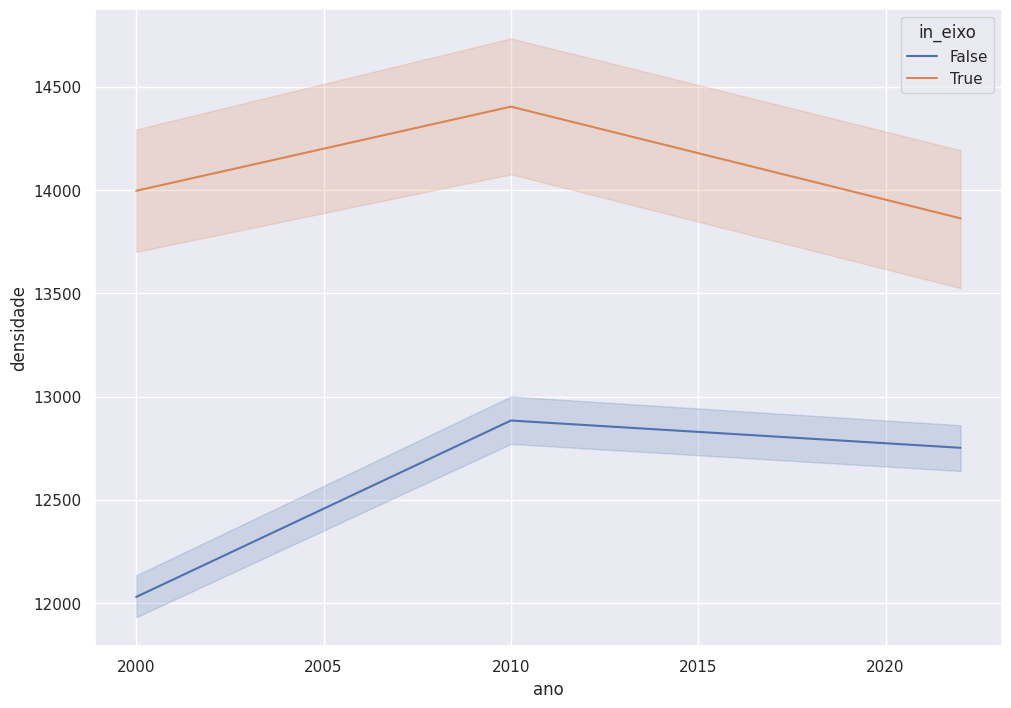

In [60]:
sns.lineplot(data=par_df, x="ano", y="densidade", hue="in_eixo")

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: xlabel='var_dens', ylabel='ano'>

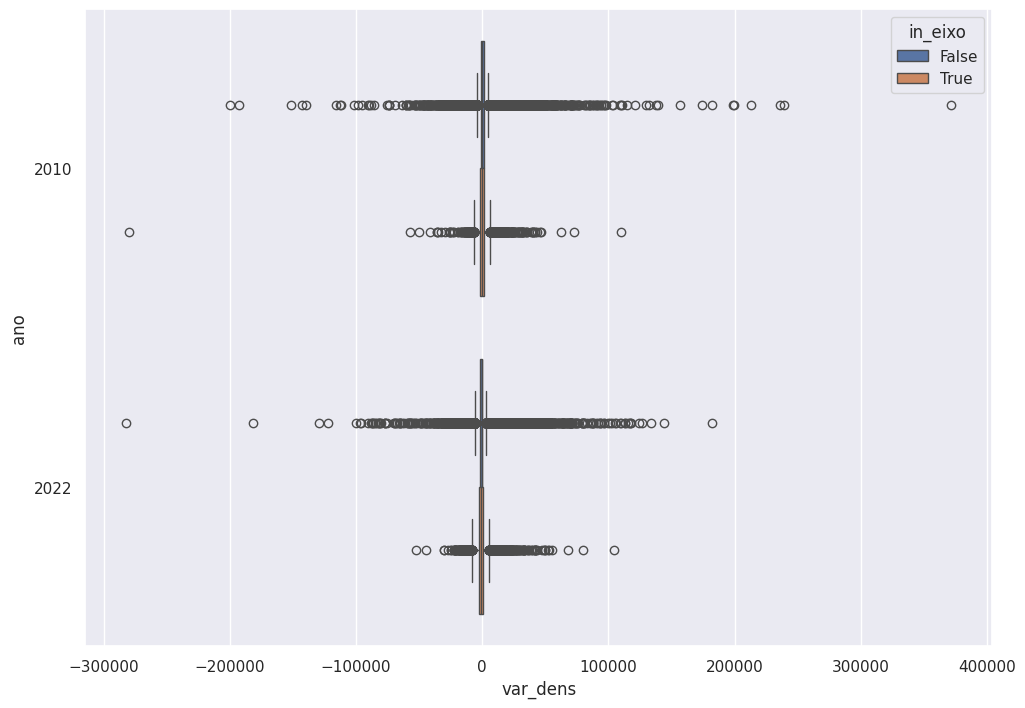

In [61]:
sns.boxplot(
        data=par_df.query('ano > 2000').assign(ano=lambda x: x['ano'].astype(str)),
        x='var_dens',
        y='ano',
        hue='in_eixo'
)

# Avaliando as regressões

In [62]:
df_reg = (
    par_df[par_df['ano']>=2010]
)
df_reg

,geometry,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total,pop_total_min,...,ult_pct_rend_2010,in_eixo,has_tombamento,in_bairro_ambiental,pct_contamin,has_risco_geol,has_mataatl,has_area_ind,has_parq_uc,has_area_pub
64784,"POLYGON ((338344.482 7407584.661, 338344.543 7...",1,52943,Quadra,1:1.000,2004,7650,SMUL/GEOINFO,94.0,0.0,...,False,False,False,False,0.0,False,False,False,False,False
64785,"POLYGON ((327186.316 7377154.793, 327188.886 7...",2,4,Praca_Canteiro,1:1.000,2004,11,SMUL/GEOINFO,0.0,0.0,...,False,False,False,False,0.0,False,False,False,False,False
64786,"POLYGON ((324545.386 7402131.104, 324544.170 7...",3,5,Praca_Canteiro,1:1.000,2004,6,SMUL/GEOINFO,0.0,0.0,...,False,False,False,False,0.0,False,False,False,False,False
64787,"POLYGON ((326273.589 7399282.971, 326273.013 7...",4,6,Praca_Canteiro,1:1.000,2004,109,SMUL/GEOINFO,0.0,0.0,...,False,False,False,False,0.0,False,False,False,False,False
64788,"POLYGON ((322149.447 7392535.031, 322154.771 7...",5,7,Praca_Canteiro,1:1.000,2004,12,SMUL/GEOINFO,0.0,0.0,...,False,False,False,False,0.0,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194347,"POLYGON ((325071.550 7397335.276, 325073.371 7...",64780,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,False,False,False,True,0.0,False,False,False,False,False
194348,"POLYGON ((325064.631 7397341.102, 325065.814 7...",64781,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,False,False,False,True,0.0,False,False,False,False,False
194349,"POLYGON ((325102.327 7397333.002, 325089.121 7...",64782,58914,Praca_Canteiro,1:1.000,2004,25982,SMUL/GEOINFO,0.0,0.0,...,False,False,False,True,0.0,False,False,False,False,False
194350,"POLYGON ((325081.631 7397226.147, 325087.148 7...",64783,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,...,False,False,False,True,0.0,False,False,False,False,False


In [63]:
df_reg.loc[:, 'ano'] = df_reg['ano'].astype(str)

/tmp/ipykernel_1463268/517704518.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['2010' '2010' '2010' ... '2022' '2022' '2022']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_reg.loc[:, 'ano'] = df_reg['ano'].astype(str)


## Analisando as variáveis de interesse e de tratamento

In [64]:
dens_std = df_reg['densidade'].describe()['std']
df_reg['densidade'].describe()

count    129568.000000
mean      12911.829667
std       14135.704558
min           0.000000
25%           0.000000
50%       11194.936738
75%       19745.863734
max      708638.360176
Name: densidade, dtype: float64

<Axes: xlabel='densidade', ylabel='Count'>

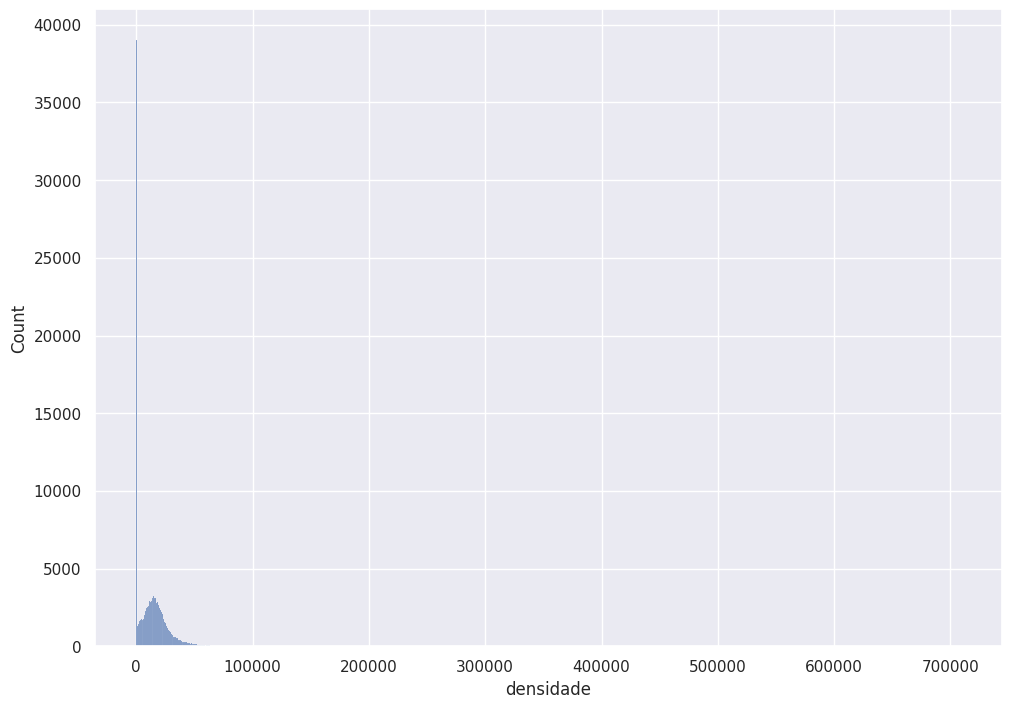

In [65]:
sns.histplot(data=df_reg, x='densidade')

Nossa variável de interesesse aparenta ser bastante assimétrica, além de não possuir valores negativos. Por isso, vamos adicionar uma versão transformada da variável para tornar o pressuposto de normalidade dos resíduos mais aceitável. De todo modo, vale ressaltar que o pressuposto de normalidade não causa nenhum viés nos estimadores dos parâmetros, interferindo apenas no estimador da matriz de covariância e nos testes estatísticos.

In [66]:
df_reg['log_densidade'] = np.log(df_reg['densidade'] + 1)
df_reg.head()

/home/d855395/git/compatibilizacao-setores-censitarios/env/lib/python3.12/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,geometry,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total,pop_total_min,...,in_eixo,has_tombamento,in_bairro_ambiental,pct_contamin,has_risco_geol,has_mataatl,has_area_ind,has_parq_uc,has_area_pub,log_densidade
64784,"POLYGON ((338344.482 7407584.661, 338344.543 7...",1,52943,Quadra,1:1.000,2004,7650,SMUL/GEOINFO,94.0,0.0,...,False,False,False,0.0,False,False,False,False,False,9.416426
64785,"POLYGON ((327186.316 7377154.793, 327188.886 7...",2,4,Praca_Canteiro,1:1.000,2004,11,SMUL/GEOINFO,0.0,0.0,...,False,False,False,0.0,False,False,False,False,False,0.000000
64786,"POLYGON ((324545.386 7402131.104, 324544.170 7...",3,5,Praca_Canteiro,1:1.000,2004,6,SMUL/GEOINFO,0.0,0.0,...,False,False,False,0.0,False,False,False,False,False,0.000000
64787,"POLYGON ((326273.589 7399282.971, 326273.013 7...",4,6,Praca_Canteiro,1:1.000,2004,109,SMUL/GEOINFO,0.0,0.0,...,False,False,False,0.0,False,False,False,False,False,0.000000
64788,"POLYGON ((322149.447 7392535.031, 322154.771 7...",5,7,Praca_Canteiro,1:1.000,2004,12,SMUL/GEOINFO,0.0,0.0,...,False,False,False,0.0,False,False,False,False,False,0.000000


<Axes: xlabel='log_densidade', ylabel='Count'>

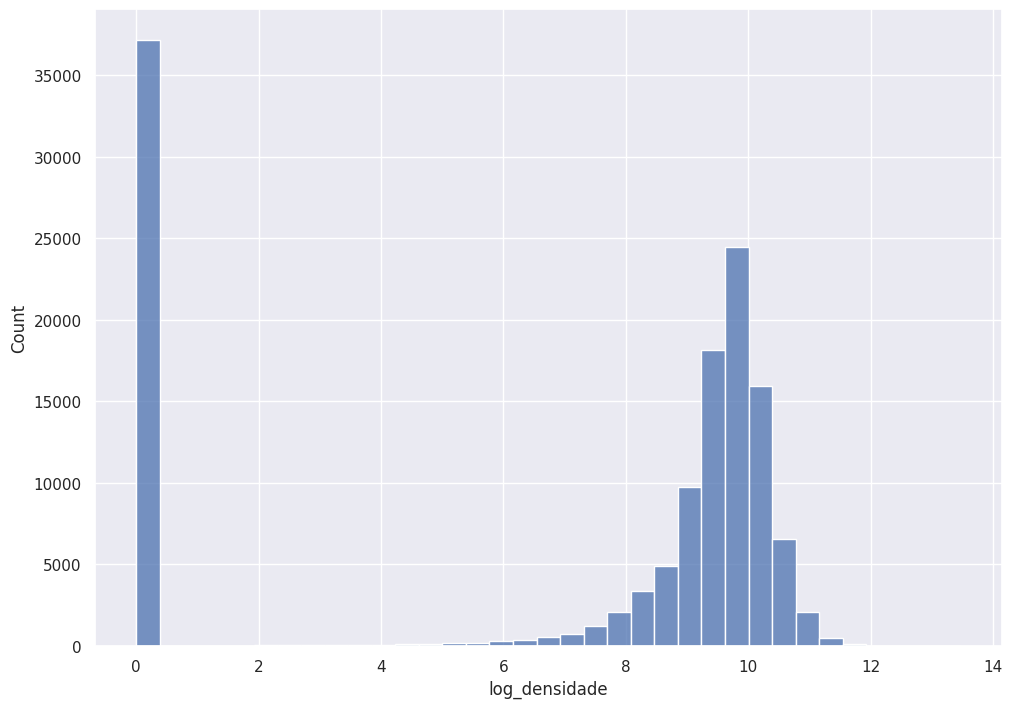

In [67]:
sns.histplot(data=df_reg, x='log_densidade')

In [68]:
log_dens_std = df_reg['log_densidade'].describe()['std']
df_reg['log_densidade'].describe()

count    129568.000000
mean          6.769162
std           4.375445
min           0.000000
25%           0.000000
50%           9.323306
75%           9.890750
max          13.471102
Name: log_densidade, dtype: float64

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: xlabel='ano', ylabel='log_densidade'>

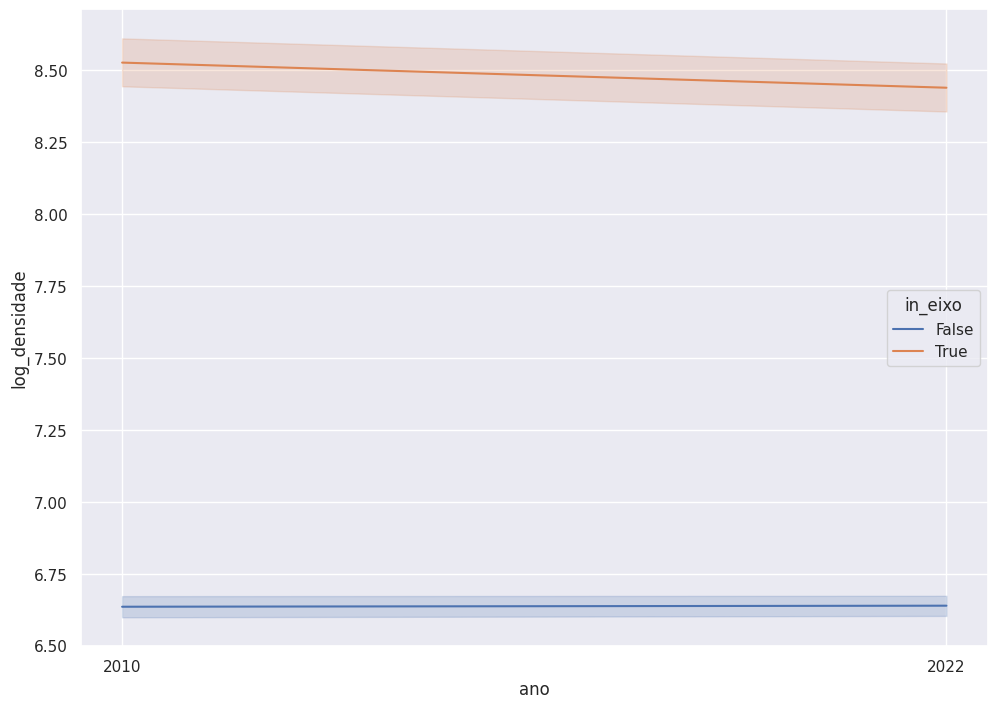

In [69]:
sns.lineplot(data=df_reg, x="ano", y="log_densidade", hue="in_eixo")

Como vemos, a tansformação da nossa variável de densidade utilizando logaritmo, apesar de se tratar de uma transformação monotônica, causou um efeito indesejado nos dados, alterando o sentido da variação no grupo controle entre os dois períodos. 

<Axes: xlabel='in_eixo', ylabel='Count'>

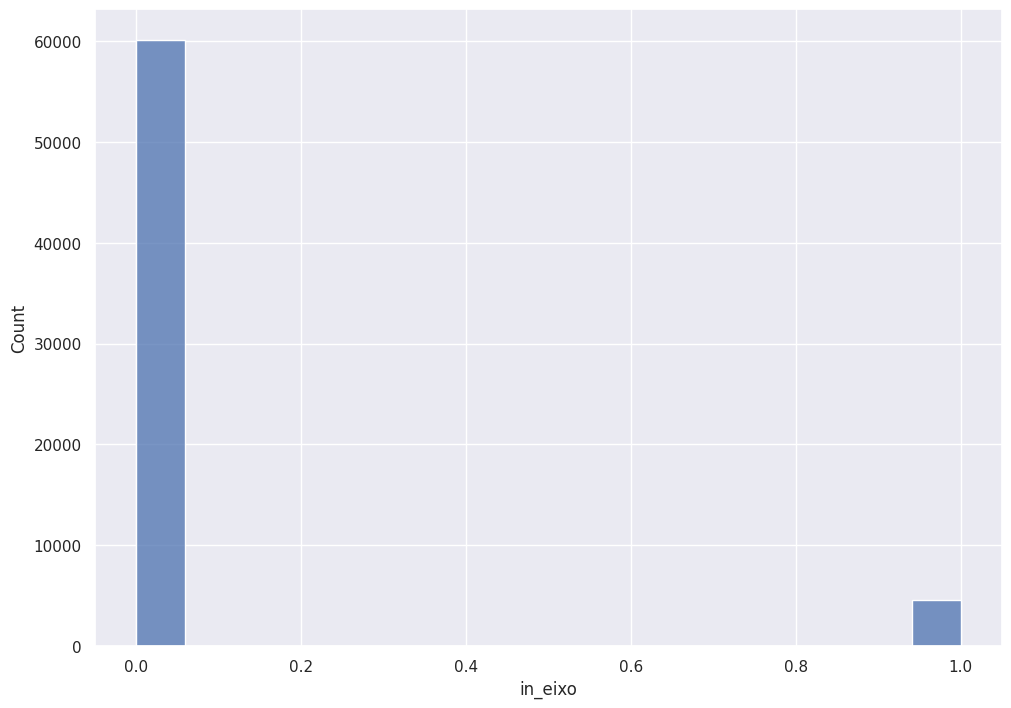

In [70]:
sns.histplot(data=df_reg.query('ano=="2022"'), x='in_eixo')

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: xlabel='densidade', ylabel='ano'>

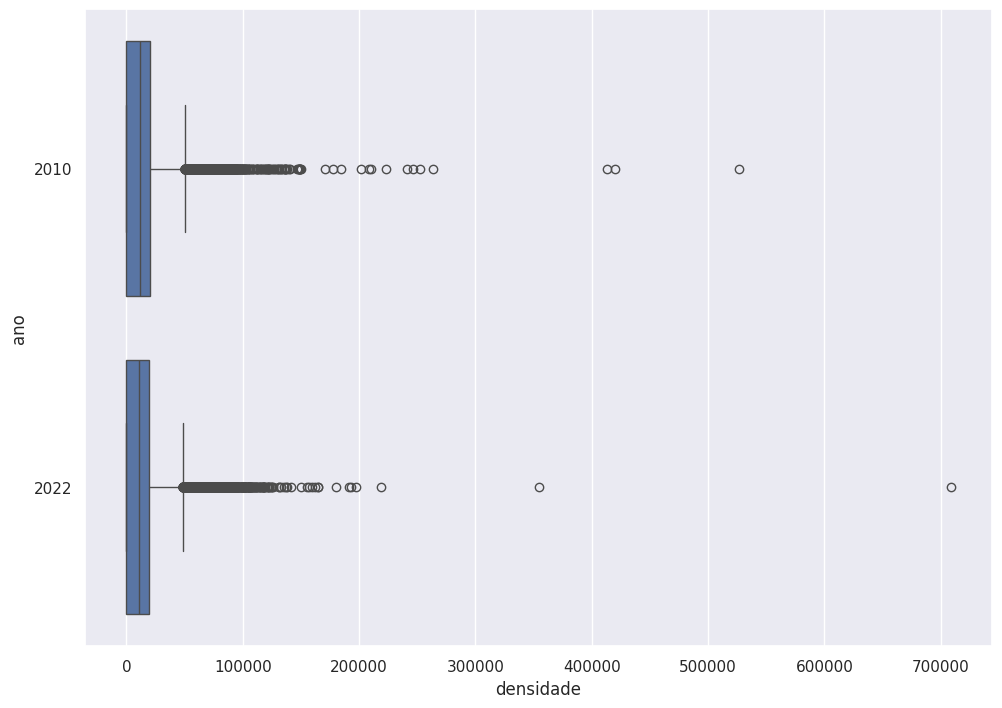

In [71]:
sns.boxplot(x=df_reg['densidade'],y=df_reg['ano'])

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: xlabel='densidade', ylabel='ano'>

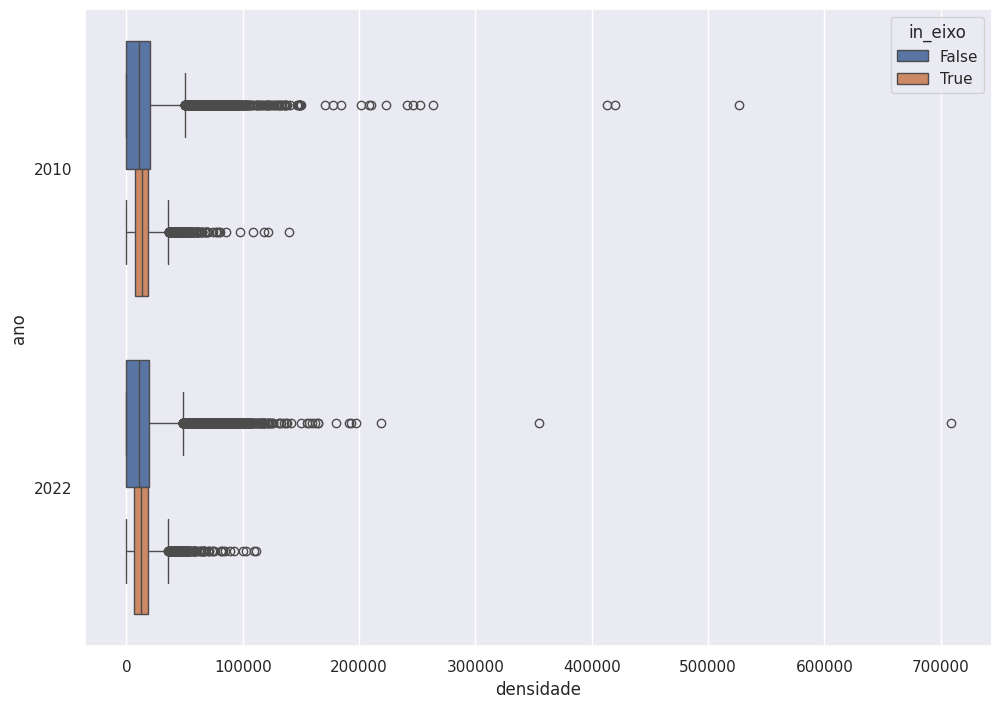

In [72]:
sns.boxplot(data=df_reg, x='densidade',y='ano', hue='in_eixo')

No geral, parece haver diferenças entre os grupos, mas não parece haver diferença entre os perídos pré e pós tratamento.

## Modelo 1: DiD clássico

Nossa regressão se baseia no método de diferenças em diferenças clássico (2x2), já que temos dois grupos (quadras no eixo e quadras fora do eixo) e dois períodos. Adaptando um trecho de [Cunningham (2021)](https://mixtape.scunning.com/09-difference_in_differences#dd-and-the-minimum-wage), podemos ver que a regressão tem a seguinte forma:

$$Y_{itg} = \alpha + \gamma IE_g + \lambda (ano=2022)_t + \delta (IE \times (ano=2022))_{st} + \varepsilon_{ite}$$

Assim, temos:

1. $E[Y|in\_eixo=0,ano=2010]=\alpha$

1. $E[Y|in\_eixo=0,ano=2022]=\alpha + \lambda$

1. $E[Y|in\_eixo=1,ano=2010]=\alpha + \gamma$

1. $E[Y|in\_eixo=1,ano=2022]=\alpha + \gamma + \lambda + \delta$

Sendo o principal coeficiente avaliado o que representa a difererença entre variação dos dois grupos após o tratamento, ou seja:

$$(E[Y|in\_eixo=1,ano=2022]-E[Y|in\_eixo=1,ano=2010])-(E[Y|in\_eixo=0,ano=2022]-E[Y|in\_eixo=0,ano=2010]) = $$

$$ (\cancel\alpha + \cancel\gamma + \lambda + \delta - \cancel\alpha - \cancel\gamma) - (\cancel\alpha + \lambda - \cancel\alpha) = $$

$$ \cancel\lambda + \delta - \cancel\lambda  = \delta $$



In [73]:
model_1 = (
    smf
    .ols('densidade ~ in_eixo*ano', data=df_reg)
)

In [74]:
model_1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              densidade   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     26.72
Date:                Wed, 24 Jul 2024   Prob (F-statistic):           2.86e-17
Time:                        00:59:07   Log-Likelihood:            -1.4220e+06
No. Observations:              129568   AIC:                         2.844e+06
Df Residuals:                  129564   BIC:                         2.844e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                    1.288e+04     57.606    223.662      0.000    1.28e+04     1.3e+04
in_eixo[T.True]              1520.0603    216.043      7.036      0.000    1096.619    1943.502
ano[T.2022]                  -132.0180     81.467     -1.620      0.105    -291.693      27.657
in_eixo[T.True]:ano[T.2022]  -408.7830    305.532     -1.338      0.181   -1007.620     190.054
==============================================================================
Omnibus:                   120902.768   Durbin-Watson:                   1.261
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         37753507.338
Skew:                           3.799   Prob(JB):                         0.00
Kurtosis:                      86.279   Cond. No.                         10.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [75]:
model_1.fit(cov_type='HC0').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              densidade   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     38.86
Date:                Wed, 24 Jul 2024   Prob (F-statistic):           4.30e-25
Time:                        00:59:08   Log-Likelihood:            -1.4220e+06
No. Observations:              129568   AIC:                         2.844e+06
Df Residuals:                  129564   BIC:                         2.844e+06
Df Model:                           3                                         
Covariance Type:                  HC0                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                    1.288e+04     58.686    219.546      0.000    1.28e+04     1.3e+04
in_eixo[T.True]              1520.0603    178.605      8.511      0.000    1170.000    1870.120
ano[T.2022]                  -132.0180     82.535     -1.600      0.110    -293.783      29.747
in_eixo[T.True]:ano[T.2022]  -408.7830    252.216     -1.621      0.105    -903.117      85.551
==============================================================================
Omnibus:                   120902.768   Durbin-Watson:                   1.261
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         37753507.338
Skew:                           3.799   Prob(JB):                         0.00
Kurtosis:                      86.279   Cond. No.                         10.2
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

In [76]:
model_1.fit(cov_type='cluster', cov_kwds={'groups': df_reg['cd_identificador_quadra_viaria_editada']}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              densidade   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     36.74
Date:                Wed, 24 Jul 2024   Prob (F-statistic):           1.03e-23
Time:                        00:59:08   Log-Likelihood:            -1.4220e+06
No. Observations:              129568   AIC:                         2.844e+06
Df Residuals:                  129564   BIC:                         2.844e+06
Df Model:                           3                                         
Covariance Type:              cluster                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                    1.288e+04     58.687    219.541      0.000    1.28e+04     1.3e+04
in_eixo[T.True]              1520.0603    178.609      8.511      0.000    1169.994    1870.127
ano[T.2022]                  -132.0180     29.818     -4.427      0.000    -190.460     -73.576
in_eixo[T.True]:ano[T.2022]  -408.7830    101.300     -4.035      0.000    -607.326    -210.239
==============================================================================
Omnibus:                   120902.768   Durbin-Watson:                   1.261
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         37753507.338
Skew:                           3.799   Prob(JB):                         0.00
Kurtosis:                      86.279   Cond. No.                         10.2
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

**Nota sobre a matriz de covariância e os testes estatísticos**

Antes de analisar os resultados, vale um comentário adicional sobre os testes estatísticos dos parâmetros.

Além da normalidade (assintótica) dos resíduos, os estimadores da matriz de covariância só são corretos em caso não exista correlação serial entre os resíduos das observações de uma mesma unidade. Entretanto, é possível pensar em correlação serial mesmo em um modelo de DiD de dois grupos e dois períodos, como abordado em [Cunningham (2021)](https://mixtape.scunning.com/09-difference_in_differences#inference).

Ainda, [Bertrand, Duflo, and Mullainathan (2004)](https://academic.oup.com/qje/article-abstract/119/1/249/1876068]) demonstram que os estimadores tradicionais são sistematicamente subestimados e rejeitam a hipótese nula (isto é, rejeitam que $\delta=0$) em até 45% de intervenções placebo nas simulações.

Uma das alternativas propostas é utilizar erros padrão clusterizados nos grupo de intervenção, que foi feito acima, e outra é agregar os dados utilizando as médias dos grupos e períodos de tratamento. Entretanto, como temos apenas 1 grupo de intervenção, isso transformaria a matriz de variáveis independentes em uma matriz 2x2, o que torna impossível a estimação dos parâmetros devido ao número de observações.


De todo modo, como estamos utilizando os dados de toda a população de interesse (no caso, quadras viárias), as estimativas para $\delta$ (isto é, o efeito da inserção de uma quadra em um dos eixos ETU do Plano Diretor) tratam-se de estimativas pontuais, sem um intervalo de confiança associado. Resta, nesse caso, a interpretação dessas estimativas em relação à magnitude das estimativas.

In [77]:
model_1.fit().params

Intercept                      12884.297492
in_eixo[T.True]                 1520.060273
ano[T.2022]                     -132.017968
in_eixo[T.True]:ano[T.2022]     -408.782955
dtype: float64

In [78]:
delta = model_1.fit().params.iloc[3]

In [79]:
delta/dens_std

-0.02891847046481775


O parâmetro foi estimado com sentido negativo, indicando uma *redução* na densidade populacional nas quadras pertencentes aos eixos ETU, que é o sentido contrário do esperado pelos formuladores do Plano. Porém, esse coeficiente representa apenas 0,03 desvio padrão da densidade populacional, o que significa que a variabilidade causada na densidade pelo pertencimento a um eixo ETU não tem relevância prática sobre a densidade populacional das quadras viárias.

## Modelo 2 e 3: associando apenas um cofator

In [80]:
model_2 = (
    smf
    .ols('densidade ~ in_eixo*ano + has_tombamento', data=df_reg)
)

In [81]:
model_2.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              densidade   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     29.19
Date:                Wed, 24 Jul 2024   Prob (F-statistic):           2.68e-24
Time:                        00:59:08   Log-Likelihood:            -1.4220e+06
No. Observations:              129568   AIC:                         2.844e+06
Df Residuals:                  129563   BIC:                         2.844e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                    1.292e+04     57.937    223.038      0.000    1.28e+04     1.3e+04
in_eixo[T.True]              1545.1276    216.054      7.152      0.000    1121.666    1968.589
ano[T.2022]                  -132.0180     81.456     -1.621      0.105    -291.671      27.635
has_tombamento[T.True]      -1463.2892    241.946     -6.048      0.000   -1937.499    -989.079
in_eixo[T.True]:ano[T.2022]  -408.7830    305.490     -1.338      0.181   -1007.537     189.971
==============================================================================
Omnibus:                   121009.662   Durbin-Watson:                   1.261
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         37832665.951
Skew:                           3.805   Prob(JB):                         0.00
Kurtosis:                      86.366   Cond. No.                         10.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [82]:
model_2.fit(cov_type='HC0').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              densidade   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     35.32
Date:                Wed, 24 Jul 2024   Prob (F-statistic):           1.57e-29
Time:                        00:59:08   Log-Likelihood:            -1.4220e+06
No. Observations:              129568   AIC:                         2.844e+06
Df Residuals:                  129563   BIC:                         2.844e+06
Df Model:                           4                                         
Covariance Type:                  HC0                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                    1.292e+04     58.811    219.724      0.000    1.28e+04     1.3e+04
in_eixo[T.True]              1545.1276    178.952      8.634      0.000    1194.389    1895.866
ano[T.2022]                  -132.0180     82.516     -1.600      0.110    -293.746      29.710
has_tombamento[T.True]      -1463.2892    292.622     -5.001      0.000   -2036.817    -889.761
in_eixo[T.True]:ano[T.2022]  -408.7830    252.576     -1.618      0.106    -903.822      86.256
==============================================================================
Omnibus:                   121009.662   Durbin-Watson:                   1.261
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         37832665.951
Skew:                           3.805   Prob(JB):                         0.00
Kurtosis:                      86.366   Cond. No.                         10.2
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

In [83]:
model_2.fit(cov_type='cluster', cov_kwds={'groups': df_reg['cd_identificador_quadra_viaria_editada']}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              densidade   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     30.91
Date:                Wed, 24 Jul 2024   Prob (F-statistic):           9.42e-26
Time:                        00:59:08   Log-Likelihood:            -1.4220e+06
No. Observations:              129568   AIC:                         2.844e+06
Df Residuals:                  129563   BIC:                         2.844e+06
Df Model:                           4                                         
Covariance Type:              cluster                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                    1.292e+04     58.921    219.311      0.000    1.28e+04     1.3e+04
in_eixo[T.True]              1545.1276    179.015      8.631      0.000    1194.265    1895.990
ano[T.2022]                  -132.0180     29.818     -4.427      0.000    -190.460     -73.576
has_tombamento[T.True]      -1463.2892    403.116     -3.630      0.000   -2253.382    -673.196
in_eixo[T.True]:ano[T.2022]  -408.7830    101.300     -4.035      0.000    -607.327    -210.239
==============================================================================
Omnibus:                   121009.662   Durbin-Watson:                   1.261
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         37832665.951
Skew:                           3.805   Prob(JB):                         0.00
Kurtosis:                      86.366   Cond. No.                         10.2
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

In [84]:
model_3 = (
    smf
    .ols('densidade ~ in_eixo*ano + in_eixo*has_tombamento', data=df_reg)
)

In [85]:
model_3.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              densidade   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     31.13
Date:                Wed, 24 Jul 2024   Prob (F-statistic):           8.80e-32
Time:                        00:59:09   Log-Likelihood:            -1.4220e+06
No. Observations:              129568   AIC:                         2.844e+06
Df Residuals:                  129562   BIC:                         2.844e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                               1.294e+04     57.971    223.145      0.000    1.28e+04     1.3e+04
in_eixo[T.True]                         1348.0615    218.324      6.175      0.000     920.149    1775.974
ano[T.2022]                             -132.0180     81.444     -1.621      0.105    -291.648      27.612
has_tombamento[T.True]                 -1996.2978    256.587     -7.780      0.000   -2499.203   -1493.393
in_eixo[T.True]:ano[T.2022]             -408.7830    305.445     -1.338      0.181   -1007.450     189.884
in_eixo[T.True]:has_tombamento[T.True]  4796.6816    769.728      6.232      0.000    3288.029    6305.335
==============================================================================
Omnibus:                   121058.745   Durbin-Watson:                   1.261
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         37892469.938
Skew:                           3.807   Prob(JB):                         0.00
Kurtosis:                      86.432   Cond. No.                         22.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [86]:
model_3.fit(cov_type='HC0').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              densidade   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     33.26
Date:                Wed, 24 Jul 2024   Prob (F-statistic):           4.78e-34
Time:                        00:59:09   Log-Likelihood:            -1.4220e+06
No. Observations:              129568   AIC:                         2.844e+06
Df Residuals:                  129562   BIC:                         2.844e+06
Df Model:                           5                                         
Covariance Type:                  HC0                                         
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                               1.294e+04     58.852    219.803      0.000    1.28e+04    1.31e+04
in_eixo[T.True]                         1348.0615    179.208      7.522      0.000     996.821    1699.302
ano[T.2022]                             -132.0180     82.514     -1.600      0.110    -293.743      29.707
has_tombamento[T.True]                 -1996.2978    317.138     -6.295      0.000   -2617.877   -1374.719
in_eixo[T.True]:ano[T.2022]             -408.7830    251.932     -1.623      0.105    -902.560      84.994
in_eixo[T.True]:has_tombamento[T.True]  4796.6816    742.947      6.456      0.000    3340.533    6252.830
==============================================================================
Omnibus:                   121058.745   Durbin-Watson:                   1.261
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         37892469.938
Skew:                           3.807   Prob(JB):                         0.00
Kurtosis:                      86.432   Cond. No.                         22.7
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

In [87]:
model_3.fit(cov_type='cluster', cov_kwds={'groups': df_reg['cd_identificador_quadra_viaria_editada']}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              densidade   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     27.09
Date:                Wed, 24 Jul 2024   Prob (F-statistic):           1.79e-27
Time:                        00:59:09   Log-Likelihood:            -1.4220e+06
No. Observations:              129568   AIC:                         2.844e+06
Df Residuals:                  129562   BIC:                         2.844e+06
Df Model:                           5                                         
Covariance Type:              cluster                                         
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                               1.294e+04     58.999    219.257      0.000    1.28e+04    1.31e+04
in_eixo[T.True]                         1348.0615    180.077      7.486      0.000     995.118    1701.005
ano[T.2022]                             -132.0180     29.818     -4.427      0.000    -190.461     -73.575
has_tombamento[T.True]                 -1996.2978    436.810     -4.570      0.000   -2852.429   -1140.167
in_eixo[T.True]:ano[T.2022]             -408.7830    101.300     -4.035      0.000    -607.328    -210.238
in_eixo[T.True]:has_tombamento[T.True]  4796.6816   1023.305      4.687      0.000    2791.041    6802.322
==============================================================================
Omnibus:                   121058.745   Durbin-Watson:                   1.261
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         37892469.938
Skew:                           3.807   Prob(JB):                         0.00
Kurtosis:                      86.432   Cond. No.                         22.7
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

## Modelo 4: associando todos os cofatores

In [88]:
no_inter = ' + '.join(covar)

model_4_formula = f'{y} ~ in_eixo*ano + {no_inter}'
model_4_formula

'densidade ~ in_eixo*ano + has_tombamento + in_bairro_ambiental + pct_contamin + has_risco_geol + has_mataatl + has_area_ind + has_parq_uc + has_area_pub'

In [89]:
model_4 = (
    smf
    .ols(model_4_formula, data=df_reg)
)

In [90]:
model_4.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              densidade   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     382.4
Date:                Wed, 24 Jul 2024   Prob (F-statistic):               0.00
Time:                        00:59:09   Log-Likelihood:            -1.4200e+06
No. Observations:              129568   AIC:                         2.840e+06
Df Residuals:                  129556   BIC:                         2.840e+06
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                    1.313e+04     58.791    223.362      0.000     1.3e+04    1.32e+04
in_eixo[T.True]              1101.9426    213.365      5.165      0.000     683.751    1520.134
ano[T.2022]                  -132.0180     80.204     -1.646      0.100    -289.215      25.180
has_tombamento[T.True]         85.9010    242.588      0.354      0.723    -389.568     561.370
in_bairro_ambiental[T.True] -1.044e+04    271.044    -38.536      0.000    -1.1e+04   -9913.711
has_risco_geol[T.True]        1.01e+04    304.096     33.210      0.000    9503.164    1.07e+04
has_mataatl[T.True]         -8105.2822    217.982    -37.183      0.000   -8532.522   -7678.042
has_area_ind[T.True]        -6889.7893   1375.559     -5.009      0.000   -9585.860   -4193.718
has_parq_uc[T.True]          -564.0422    228.790     -2.465      0.014   -1012.466    -115.619
has_area_pub[T.True]         2054.4588    151.514     13.560      0.000    1757.494    2351.423
in_eixo[T.True]:ano[T.2022]  -408.7830    300.791     -1.359      0.174    -998.329     180.763
pct_contamin                   66.3459     89.833      0.739      0.460    -109.726     242.418
==============================================================================
Omnibus:                   122558.108   Durbin-Watson:                   1.282
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         41697331.137
Skew:                           3.867   Prob(JB):                         0.00
Kurtosis:                      90.543   Cond. No.                         41.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [91]:
model_4.fit(cov_type='HC0').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              densidade   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     1432.
Date:                Wed, 24 Jul 2024   Prob (F-statistic):               0.00
Time:                        00:59:09   Log-Likelihood:            -1.4200e+06
No. Observations:              129568   AIC:                         2.840e+06
Df Residuals:                  129556   BIC:                         2.840e+06
Df Model:                          11                                         
Covariance Type:                  HC0                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                    1.313e+04     59.403    221.063      0.000     1.3e+04    1.32e+04
in_eixo[T.True]              1101.9426    178.188      6.184      0.000     752.700    1451.185
ano[T.2022]                  -132.0180     81.211     -1.626      0.104    -291.189      27.153
has_tombamento[T.True]         85.9010    294.157      0.292      0.770    -490.635     662.437
in_bairro_ambiental[T.True] -1.044e+04     97.301   -107.347      0.000   -1.06e+04   -1.03e+04
has_risco_geol[T.True]        1.01e+04    516.628     19.548      0.000    9086.615    1.11e+04
has_mataatl[T.True]         -8105.2822    240.124    -33.755      0.000   -8575.917   -7634.647
has_area_ind[T.True]        -6889.7893    496.275    -13.883      0.000   -7862.471   -5917.107
has_parq_uc[T.True]          -564.0422    265.352     -2.126      0.034   -1084.122     -43.962
has_area_pub[T.True]         2054.4588    178.021     11.541      0.000    1705.545    2403.373
in_eixo[T.True]:ano[T.2022]  -408.7830    250.529     -1.632      0.103    -899.811      82.245
pct_contamin                   66.3459    115.569      0.574      0.566    -160.165     292.857
==============================================================================
Omnibus:                   122558.108   Durbin-Watson:                   1.282
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         41697331.137
Skew:                           3.867   Prob(JB):                         0.00
Kurtosis:                      90.543   Cond. No.                         41.0
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

In [92]:
model_4.fit(cov_type='cluster', cov_kwds={'groups': df_reg['cd_identificador_quadra_viaria_editada']}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              densidade   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     764.5
Date:                Wed, 24 Jul 2024   Prob (F-statistic):               0.00
Time:                        00:59:09   Log-Likelihood:            -1.4200e+06
No. Observations:              129568   AIC:                         2.840e+06
Df Residuals:                  129556   BIC:                         2.840e+06
Df Model:                          11                                         
Covariance Type:              cluster                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                    1.313e+04     60.447    217.244      0.000     1.3e+04    1.33e+04
in_eixo[T.True]              1101.9426    178.820      6.162      0.000     751.462    1452.423
ano[T.2022]                  -132.0180     29.819     -4.427      0.000    -190.462     -73.574
has_tombamento[T.True]         85.9010    404.226      0.213      0.832    -706.367     878.169
in_bairro_ambiental[T.True] -1.044e+04    134.548    -77.630      0.000   -1.07e+04   -1.02e+04
has_risco_geol[T.True]        1.01e+04    707.369     14.277      0.000    8712.770    1.15e+04
has_mataatl[T.True]         -8105.2822    328.432    -24.679      0.000   -8748.996   -7461.568
has_area_ind[T.True]        -6889.7893    662.724    -10.396      0.000   -8188.705   -5590.873
has_parq_uc[T.True]          -564.0422    365.487     -1.543      0.123   -1280.383     152.298
has_area_pub[T.True]         2054.4588    241.082      8.522      0.000    1581.946    2526.971
in_eixo[T.True]:ano[T.2022]  -408.7830    101.303     -4.035      0.000    -607.333    -210.233
pct_contamin                   66.3459    145.501      0.456      0.648    -218.831     351.522
==============================================================================
Omnibus:                   122558.108   Durbin-Watson:                   1.282
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         41697331.137
Skew:                           3.867   Prob(JB):                         0.00
Kurtosis:                      90.543   Cond. No.                         41.0
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""


As diferentes formas funcionais e cofatores testadas não alteram o valor estimado para $\delta$, o que reduz as chances de viés de variável omitida no modelo.

## Modelo 5: Primeiras diferenças

In [93]:
df_reg['in_eixo'].value_counts()

in_eixo
False    120356
True       9212
Name: count, dtype: int64

In [94]:
model_5 = (
    smf
    .ols('var_dens ~ in_eixo - 1', data=df_reg.query('ano=="2022"'))
)

In [95]:
model_5.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               var_dens   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     13.55
Date:                Wed, 24 Jul 2024   Prob (F-statistic):           0.000233
Time:                        00:59:10   Log-Likelihood:            -6.6790e+05
No. Observations:               64784   AIC:                         1.336e+06
Df Residuals:                   64782   BIC:                         1.336e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
in_eixo[False]  -132.0180     29.612     -4.458      0.000    -190.058     -73.978
in_eixo[True]   -540.8009    107.036     -5.053      0.000    -750.592    -331.010
==============================================================================
Omnibus:                    42997.185   Durbin-Watson:                   1.753
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         24899839.179
Skew:                           1.898   Prob(JB):                         0.00
Kurtosis:                      98.969   Cond. No.                         3.61
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

O modelo em primeiras diferenças (isto é, com a variação na densidade como variável dependente e avaliado apenas para o último ano) deixa de eliminar um dos viéses eliminado pelo DiD.

Como ele executa apenas uma diferença, entre um período e o período anterior, ele remove apenas efeitos não observados relacionados aos períodos, mas não aos grupos de tratados e não tratados. Para remover estes últimos, é necessário mais uma diferenciação.

Pela praticidade, vou utilizar a classe PanelOLS, que implementa o modelo com duas diferenciações, normalmente chamado de Two-Way Fixed Effects (TWFE). Vale ressaltar que, por definição, o coeficiente da nossa variável dependente deve ser o mesmo do modelo DiD clássico.

In [96]:
df_reg.loc[:, 'treated'] = df_reg['in_eixo'] * (df_reg['ano']=='2022')
df_reg['treated'].value_counts()

/home/d855395/git/compatibilizacao-setores-censitarios/env/lib/python3.12/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


treated
False    124962
True       4606
Name: count, dtype: int64

In [97]:
mod = PanelOLS.from_formula(f'densidade ~ treated + EntityEffects + TimeEffects',
                            data=pd.DataFrame(df_reg.assign(ano=df_reg['ano'].astype(int))).set_index(["cd_identificador_quadra_viaria_editada", "ano"]))

result = mod.fit(cov_type='robust')
result.summary

Dep. Variable:,densidade,R-squared:,0.0002
Estimator:,PanelOLS,R-squared (Between):,-0.0012
No. Observations:,129568,R-squared (Within):,0.0004
Date:,"Wed, Jul 24 2024",R-squared (Overall):,-0.0011
Time:,00:59:10,Log-likelihood,-1.246e+06
Cov. Estimator:,Robust,,
,,F-statistic:,13.549
Entities:,64784,P-value,0.0002
Avg Obs:,2.0000,Distribution:,"F(1,64782)"
Min Obs:,2.0000,,
Max Obs:,2.0000,F-statistic (robust):,16.284


## Modelo 6: Efeitos dos cofatores variam ao longo do tempo

### Demonstrar invalidade do pressuposto na diferenciação

In [98]:
df_reg_2 = df_reg.copy()

In [99]:
filtro_pos = df_reg_2['ano']=='2022'
for cv in covar:
    if cv == 'pct_contamin':
        df_reg_2.loc[~filtro_pos, cv] = 0
    else:
        df_reg_2.loc[~filtro_pos, cv] = False
df_reg_2[['ano'] + covar]

,ano,has_tombamento,in_bairro_ambiental,pct_contamin,has_risco_geol,has_mataatl,has_area_ind,has_parq_uc,has_area_pub
64784,2010,False,False,0.0,False,False,False,False,False
64785,2010,False,False,0.0,False,False,False,False,False
64786,2010,False,False,0.0,False,False,False,False,False
64787,2010,False,False,0.0,False,False,False,False,False
64788,2010,False,False,0.0,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
194347,2022,False,True,0.0,False,False,False,False,False
194348,2022,False,True,0.0,False,False,False,False,False
194349,2022,False,True,0.0,False,False,False,False,False
194350,2022,False,True,0.0,False,False,False,False,False


In [100]:
df_reg_2 = pd.DataFrame(
    df_reg_2
    .assign(ano=df_reg['ano'].astype(int))
)
df_reg_2 = df_reg_2.set_index(["cd_identificador_quadra_viaria_editada", "ano"])

In [101]:
model_6_formula = f'var_dens ~ treated + {no_inter}'
model_6_formula

'var_dens ~ treated + has_tombamento + in_bairro_ambiental + pct_contamin + has_risco_geol + has_mataatl + has_area_ind + has_parq_uc + has_area_pub'

In [102]:
filtro_pos_index = df_reg_2.index.get_level_values('ano').isin([2022])

model_6 = (
    smf
    .ols(model_6_formula, data=df_reg_2[filtro_pos_index])
)

In [103]:
model_6.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               var_dens   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     47.91
Date:                Wed, 24 Jul 2024   Prob (F-statistic):           5.86e-87
Time:                        00:59:11   Log-Likelihood:            -6.6769e+05
No. Observations:               64784   AIC:                         1.335e+06
Df Residuals:                   64774   BIC:                         1.335e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                    -285.2335     31.646     -9.013      0.000    -347.260    -223.207
treated[T.True]              -450.9724    111.407     -4.048      0.000    -669.330    -232.614
has_tombamento[T.True]       -104.3730    178.571     -0.584      0.559    -454.373     245.627
in_bairro_ambiental[T.True]  -136.5359    199.517     -0.684      0.494    -527.590     254.518
has_risco_geol[T.True]       2483.9397    223.848     11.097      0.000    2045.198    2922.681
has_mataatl[T.True]           870.3860    160.458      5.424      0.000     555.888    1184.884
has_area_ind[T.True]           45.7461   1012.559      0.045      0.964   -1938.870    2030.362
has_parq_uc[T.True]           198.2423    168.414      1.177      0.239    -131.849     528.333
has_area_pub[T.True]          803.2627    111.530      7.202      0.000     584.663    1021.862
pct_contamin                  786.4599     66.127     11.893      0.000     656.851     916.069
==============================================================================
Omnibus:                    42367.678   Durbin-Watson:                   1.762
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         25213101.769
Skew:                           1.838   Prob(JB):                         0.00
Kurtosis:                      99.576   Cond. No.                         35.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [104]:
model_6.fit(cov_type='HC1').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               var_dens   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     24.99
Date:                Wed, 24 Jul 2024   Prob (F-statistic):           2.35e-43
Time:                        00:59:11   Log-Likelihood:            -6.6769e+05
No. Observations:               64784   AIC:                         1.335e+06
Df Residuals:                   64774   BIC:                         1.335e+06
Df Model:                           9                                         
Covariance Type:                  HC1                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                    -285.2335     30.803     -9.260      0.000    -345.607    -224.860
treated[T.True]              -450.9724    101.634     -4.437      0.000    -650.172    -251.773
has_tombamento[T.True]       -104.3730    196.734     -0.531      0.596    -489.965     281.219
in_bairro_ambiental[T.True]  -136.5359     57.652     -2.368      0.018    -249.531     -23.540
has_risco_geol[T.True]       2483.9397    357.234      6.953      0.000    1783.774    3184.105
has_mataatl[T.True]           870.3860    169.897      5.123      0.000     537.394    1203.378
has_area_ind[T.True]           45.7461    462.855      0.099      0.921    -861.433     952.925
has_parq_uc[T.True]           198.2423    170.508      1.163      0.245    -135.948     532.433
has_area_pub[T.True]          803.2627    144.429      5.562      0.000     520.188    1086.338
pct_contamin                  786.4599    140.768      5.587      0.000     510.559    1062.361
==============================================================================
Omnibus:                    42367.678   Durbin-Watson:                   1.762
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         25213101.769
Skew:                           1.838   Prob(JB):                         0.00
Kurtosis:                      99.576   Cond. No.                         35.9
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [105]:
mod = PanelOLS.from_formula(f'densidade ~ treated + has_tombamento + in_bairro_ambiental + pct_contamin + has_risco_geol + has_mataatl + has_area_ind + has_parq_uc + has_area_pub + EntityEffects + TimeEffects',
                            data=df_reg_2)

result = mod.fit(cov_type='robust')
result.summary

Dep. Variable:,densidade,R-squared:,0.0066
Estimator:,PanelOLS,R-squared (Between):,0.0050
No. Observations:,129568,R-squared (Within):,0.0056
Date:,"Wed, Jul 24 2024",R-squared (Overall):,0.0050
Time:,00:59:11,Log-likelihood,-1.246e+06
Cov. Estimator:,Robust,,
,,F-statistic:,47.915
Entities:,64784,P-value,0.0000
Avg Obs:,2.0000,Distribution:,"F(9,64774)"
Min Obs:,2.0000,,
Max Obs:,2.0000,F-statistic (robust):,24.988


In [106]:
df_reg_2.loc[filtro_pos_index, 'var_dens'].describe()

count     64784.000000
mean       -161.081538
std        7264.976764
min     -282021.151586
25%       -2253.618797
50%           0.000000
75%           0.000000
max      181844.802343
Name: var_dens, dtype: float64

In [107]:
df_reg_2.loc[filtro_pos_index].groupby('in_eixo')['var_dens'].describe()

,count,mean,std,min,25%,50%,75%,max
in_eixo,,,,,,,,
False,60178.0,-132.017968,7314.622751,-282021.151586,-2173.153201,0.000000,0.000000,181844.802343
True,4606.0,-540.800923,6570.951992,-52506.265664,-2950.642777,-908.479416,454.676948,104599.406528


<Axes: xlabel='var_dens'>

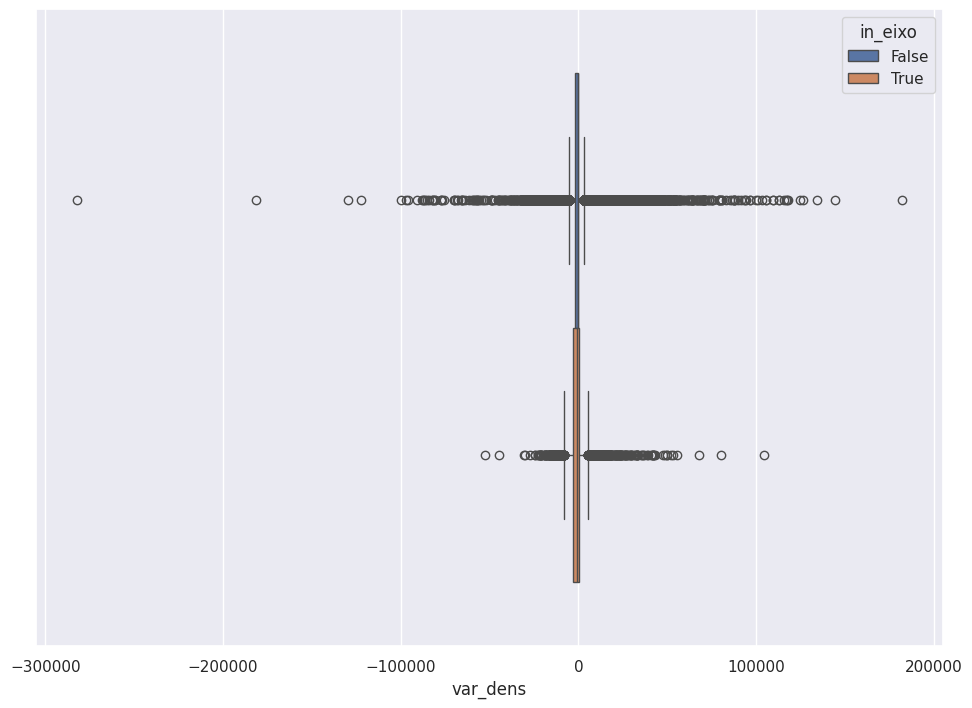

In [108]:
sns.boxplot(data=df_reg_2[filtro_pos_index], x='var_dens', hue='in_eixo')

## Modelo 7 e 8: Interação com renda *per capita*

Por último, vamos avaliar o quanto a renda prévia de cada quadra influcencia no aumento da sua densidade. Aqui, utilizamos a renda como *proxy* para o valor da terra, que por sua vez sinaliza a demanda pelos terrenos daquela quadra.

In [109]:
df_reg_2['ult_5_pct_rend_2010'] = (
    df_reg_2['rend_pc_2010'] >= df_reg_2['rend_pc_2010'].quantile(0.95)
)

In [110]:
no_inter = ' + '.join(covar)

model_7_formula = f'var_dens ~ treated*ult_pct_rend_2010  + {no_inter}'
model_7_formula

'var_dens ~ treated*ult_pct_rend_2010  + has_tombamento + in_bairro_ambiental + pct_contamin + has_risco_geol + has_mataatl + has_area_ind + has_parq_uc + has_area_pub'

In [111]:
model_7 = (
    smf
    .ols(model_7_formula, data=df_reg_2[filtro_pos_index])
)

In [112]:
model_7.fit(cov_type='HC0').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               var_dens   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     21.43
Date:                Wed, 24 Jul 2024   Prob (F-statistic):           3.24e-44
Time:                        00:59:12   Log-Likelihood:            -6.6769e+05
No. Observations:               64784   AIC:                         1.335e+06
Df Residuals:                   64772   BIC:                         1.336e+06
Df Model:                          11                                         
Covariance Type:                  HC0                                         
=============================================================================================================
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                  -286.3135     30.864     -9.277      0.000    -346.806    -225.821
treated[T.True]                            -423.9246    102.396     -4.140      0.000    -624.617    -223.232
ult_pct_rend_2010[T.True]                   104.4222    244.521      0.427      0.669    -374.830     583.675
has_tombamento[T.True]                     -101.2034    196.706     -0.514      0.607    -486.740     284.333
in_bairro_ambiental[T.True]                -134.7135     60.407     -2.230      0.026    -253.109     -16.318
has_risco_geol[T.True]                     2483.0985    357.223      6.951      0.000    1782.953    3183.244
has_mataatl[T.True]                         871.1296    169.917      5.127      0.000     538.099    1204.160
has_area_ind[T.True]                         45.5234    462.841      0.098      0.922    -861.628     952.675
has_parq_uc[T.True]                         195.9895    170.516      1.149      0.250    -138.215     530.194
has_area_pub[T.True]                        807.5471    144.469      5.590      0.000     524.394    1090.700
treated[T.True]:ult_pct_rend_2010[T.True] -2309.4128    683.272     -3.380      0.001   -3648.602    -970.224
pct_contamin                                787.7470    140.746      5.597      0.000     511.889    1063.605
==============================================================================
Omnibus:                    42367.891   Durbin-Watson:                   1.762
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         25219766.604
Skew:                           1.838   Prob(JB):                         0.00
Kurtosis:                      99.589   Cond. No.                         37.1
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

In [113]:
delta_7 = model_7.fit().params.loc['treated[T.True]']

In [114]:
dens_std

14135.704557584455

In [115]:
delta_7/dens_std

-0.02998963548979465

In [116]:
gamma = (
    model_7.fit().params.loc['treated[T.True]']
    + model_7.fit().params.loc['ult_pct_rend_2010[T.True]']
    + model_7.fit().params.loc['treated[T.True]:ult_pct_rend_2010[T.True]']
)
gamma/dens_std

-0.18597695270659723

In [117]:
no_inter = ' + '.join(covar)

model_8_formula = f'var_dens ~ treated*ult_5_pct_rend_2010  + {no_inter}'
model_8_formula

'var_dens ~ treated*ult_5_pct_rend_2010  + has_tombamento + in_bairro_ambiental + pct_contamin + has_risco_geol + has_mataatl + has_area_ind + has_parq_uc + has_area_pub'

In [118]:
model_8 = (
    smf
    .ols(model_8_formula, data=df_reg_2[filtro_pos_index])
)

In [119]:
model_8.fit(cov_type='HC0').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               var_dens   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     20.53
Date:                Wed, 24 Jul 2024   Prob (F-statistic):           3.80e-42
Time:                        00:59:12   Log-Likelihood:            -6.6769e+05
No. Observations:               64784   AIC:                         1.335e+06
Df Residuals:                   64772   BIC:                         1.336e+06
Df Model:                          11                                         
Covariance Type:                  HC0                                         
===============================================================================================================
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                    -288.0726     31.179     -9.239      0.000    -349.181    -226.964
treated[T.True]                              -361.7532    104.007     -3.478      0.001    -565.603    -157.903
ult_5_pct_rend_2010[T.True]                    29.7542    160.190      0.186      0.853    -284.212     343.720
has_tombamento[T.True]                        -82.6419    197.760     -0.418      0.676    -470.245     304.961
in_bairro_ambiental[T.True]                  -136.9927     71.849     -1.907      0.057    -277.815       3.829
has_risco_geol[T.True]                       2480.0777    357.270      6.942      0.000    1779.842    3180.313
has_mataatl[T.True]                           867.3469    169.836      5.107      0.000     534.475    1200.219
has_area_ind[T.True]                           41.9091    463.084      0.090      0.928    -865.720     949.538
has_parq_uc[T.True]                           191.0830    170.617      1.120      0.263    -143.320     525.486
has_area_pub[T.True]                          824.2512    145.618      5.660      0.000     538.845    1109.657
treated[T.True]:ult_5_pct_rend_2010[T.True]  -780.6153    390.307     -2.000      0.045   -1545.603     -15.628
pct_contamin                                  787.2333    140.794      5.591      0.000     511.283    1063.184
==============================================================================
Omnibus:                    42375.498   Durbin-Watson:                   1.762
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         25219724.402
Skew:                           1.839   Prob(JB):                         0.00
Kurtosis:                      99.589   Cond. No.                         35.9
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

In [120]:
delta_8 = model_8.fit().params.loc['treated[T.True]']

In [121]:
dens_std

14135.704557584455

In [122]:
delta_8/dens_std

-0.02559145196273334

In [123]:
gamma = (
    model_8.fit().params.loc['treated[T.True]']
    + model_8.fit().params.loc['ult_5_pct_rend_2010[T.True]']
    + model_8.fit().params.loc['treated[T.True]:ult_5_pct_rend_2010[T.True]']
)
gamma/dens_std

-0.07870950255343444


Como esperado, ao introduzir a *dummy* do último decil de renda *per capita* em 2010, temos uma variação no coeficiente relacionado ao tratamento (`in_eixo[T.True]:ano[T.2022]`). Entretanto a variação é pequena (0,008 desvio padrão), o que torna o efeito insignificante na prática.

Entretanto, também como esperado, as quadras com maior renda e pertencentes ao eixo apresentavam, em 2010, maior densidade populacional (conforme o coeficiente `in_eixo[T.True]:ult_decil_rend_2010[T.True]`). Essa diferença é muito mais significativa praticamente (0,364 desvio padrão) e pode explicar a impressão anedótica de que os EETUs tem causado verticalização.

# Tabelas de comparação usadas no texto

In [124]:
rename_map = {
    'Intercept': 'Intercepto',
    'ano[T.2022]': 'Ano=2022',
    'in_eixo[T.True]': 'Grupo EETU',
    'in_eixo[T.True]:ano[T.2022]': 'Grupo EETU em 2022',
    'has_area_ind[T.True]': 'Possui área indígena',
    'has_area_pub[T.True]': 'Possui área pública',
    'has_mataatl[T.True]': 'Possui Mata Atlântica',
    'has_parq_uc[T.True]': 'Possui Unidade de Conservação',
    'has_risco_geol[T.True]': 'Possui área de risco geológico',
    'has_tombamento[T.True]': 'Possui imóvel tombado',
    'in_bairro_ambiental[T.True]': 'Está em um bairro ambiental',
    'pct_contamin': 'Percentual de área contaminada'
}

In [125]:
sg = Stargazer([
    model_1.fit(),
    model_1.fit(cov_type='cluster', cov_kwds={'groups': df_reg['cd_identificador_quadra_viaria_editada']}),
    model_4.fit(),
    model_4.fit(cov_type='cluster', cov_kwds={'groups': df_reg['cd_identificador_quadra_viaria_editada']})
])

In [126]:
sg.dependent_variable_name('Densidade demográfica (hab/km²)')
sg.custom_columns(['Modelo 1', 'Modelo 2'], [2,2])
sg.show_model_numbers(False)
sg.rename_covariates(rename_map)
sg.covariate_order(rename_map.keys())
sg.add_line('Erros padrão robustos', ['Não', 'Sim', 'Não', 'Sim'], LineLocation.HEADER_BOTTOM)
sg

In [127]:
rename_map2 = {
    'Intercept': 'Intercepto',
    'treated[T.True]': 'Grupo EETU',
    'has_area_ind[T.True]': 'Possui área indígena',
    'has_area_pub[T.True]': 'Possui área pública',
    'has_mataatl[T.True]': 'Possui Mata Atlântica',
    'has_parq_uc[T.True]': 'Possui Unidade de Conservação',
    'has_risco_geol[T.True]': 'Possui área de risco geológico',
    'has_tombamento[T.True]': 'Possui imóvel tombado',
    'in_bairro_ambiental[T.True]': 'Está em um bairro ambiental',
    'pct_contamin': 'Percentual de área contaminada'
}

In [128]:
sg2 = Stargazer([
    model_6.fit(),
    model_6.fit(cov_type='HC1')
])

In [129]:
sg2.dependent_variable_name('Variação na densidade demográfica (hab/km²)')
sg2.custom_columns(['Modelo 3'], [2])
sg2.show_model_numbers(False)
sg2.rename_covariates(rename_map2)
sg2.covariate_order(rename_map2.keys())
sg2.add_line('Erros padrão robustos', ['Não', 'Sim'], LineLocation.HEADER_BOTTOM)
sg2